## PTSA final project

In [60]:
!scp *.png  drive/MyDrive/

### Deal with dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
## Ithaca hourly data
url = 'https://raw.githubusercontent.com/TLI2958/PTSA_project/main/hourly02-ithaca/hourly02-NY_Ithaca_13_E.csv'
Ithaca_hourly = pd.read_csv(url, index_col = 0)

## NYC central park data 1990-2023
url = 'https://raw.githubusercontent.com/TLI2958/PTSA_project/main/nyc_daily/3508670.csv'
nyc_daily = pd.read_csv(url, delimiter=',')
nyc_daily.isnull().sum() # no missing values for TMIN, TMAX per day


STATION        0
NAME           0
DATE           0
ACMH       12357
AWND        2389
PRCP           0
SNOW           0
SNWD         834
TAVG        9710
TMAX           0
TMIN           0
TSUN        9472
WT01        8472
WT02       12000
WT03       12064
WT04       12306
WT05       12046
WT06       12283
WT07       12267
WT08       10433
WT09       12338
WT11       12353
WT13       10034
WT14       12126
WT15       12344
WT16        9104
WT17       12298
WT18       11767
WT19       12179
WT21       12357
WT22       12273
dtype: int64

##### Ithaca hourly

In [ ]:
Ithaca_hourly = Ithaca_hourly.loc[:, ['UTC_DATE','UTC_TIME','T_HR_AVG']]
Ithaca_hourly.dropna(inplace = True)
Ithaca_hourly = Ithaca_hourly.reset_index().drop('index', axis = 1)
Ithaca_hourly

UTC_DATE  UTC_TIME  T_HR_AVG
0       20041028         0       7.6
1       20041028       100       7.0
2       20041028       200       6.2
3       20041028       300       4.7
4       20041028       400       3.3
...          ...       ...       ...
165308  20231106         0       1.3
165309  20231106       100       0.0
165310  20231106       200      -0.4
165311  20231106       300      -1.3
165312  20231106       400      -1.6

[165313 rows x 3 columns]

In [ ]:
Date = (pd.to_datetime(Ithaca_hourly.UTC_DATE, format='%Y%m%d', errors='coerce')
+ pd.to_timedelta(Ithaca_hourly.UTC_TIME//100, unit = 'hours'))

Ithaca_hourly['Time'] = Date
Ithaca_hourly.to_json('Ithaca_hourly.json')


In [ ]:
Ithaca_hourly

UTC_DATE  UTC_TIME  T_HR_AVG                Time
0       20041028         0       7.6 2004-10-28 00:00:00
1       20041028       100       7.0 2004-10-28 01:00:00
2       20041028       200       6.2 2004-10-28 02:00:00
3       20041028       300       4.7 2004-10-28 03:00:00
4       20041028       400       3.3 2004-10-28 04:00:00
...          ...       ...       ...                 ...
165308  20231106         0       1.3 2023-11-06 00:00:00
165309  20231106       100       0.0 2023-11-06 01:00:00
165310  20231106       200      -0.4 2023-11-06 02:00:00
165311  20231106       300      -1.3 2023-11-06 03:00:00
165312  20231106       400      -1.6 2023-11-06 04:00:00

[165313 rows x 4 columns]

##### NYC daily

In [ ]:
Date = pd.to_datetime(nyc_daily.DATE, format='%Y-%m-%d', errors='coerce')
nyc_daily['year'], nyc_daily['month'], nyc_daily['day'] = Date.dt.year, Date.dt.month, Date.dt.day
nyc_daily

STATION                         NAME        DATE  ACMH  AWND  PRCP  \
0      USW00094728  NY CITY CENTRAL PARK, NY US  1990-01-01   NaN   NaN  0.24   
1      USW00094728  NY CITY CENTRAL PARK, NY US  1990-01-02   NaN   NaN  0.00   
2      USW00094728  NY CITY CENTRAL PARK, NY US  1990-01-03   NaN   NaN  0.00   
3      USW00094728  NY CITY CENTRAL PARK, NY US  1990-01-04   NaN   NaN  0.01   
4      USW00094728  NY CITY CENTRAL PARK, NY US  1990-01-05   NaN   NaN  0.00   
...            ...                          ...         ...   ...   ...   ...   
12353  USW00094728  NY CITY CENTRAL PARK, NY US  2023-10-28   NaN  4.92  0.00   
12354  USW00094728  NY CITY CENTRAL PARK, NY US  2023-10-29   NaN  6.93  0.47   
12355  USW00094728  NY CITY CENTRAL PARK, NY US  2023-10-30   NaN  4.47  0.59   
12356  USW00094728  NY CITY CENTRAL PARK, NY US  2023-10-31   NaN  3.80  0.00   
12357  USW00094728  NY CITY CENTRAL PARK, NY US  2023-11-01   NaN  6.71  0.01   

       SNOW  SNWD  TAVG  TMAX  ...  WT15  WT16  WT17  WT18  WT19  WT21  WT22  \
0       0.0   0.0   NaN    48  ...   NaN   1.0   NaN   NaN   NaN   NaN   NaN   
1       0.0   0.0   NaN    44  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2       0.0   0.0   NaN    53  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3       0.0   0.0   NaN    51  ...   NaN   1.0   NaN   NaN   NaN   NaN   NaN   
4       0.0   0.0   NaN    49  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...     ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   
12353   0.0   0.0   NaN    80  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
12354   0.0   0.0   NaN    63  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
12355   0.0   0.0   NaN    60  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
12356   0.0   0.0   NaN    51  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
12357   0.0   0.0   NaN    49  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

       year  month  day  
0      1990      1    1  
1      1990      1    2  
2      1990      1    3  
3      1990      1    4  
4      1990      1    5  
...     ...    ...  ...  
12353  2023     10   28  
12354  2023     10   29  
12355  2023     10   30  
12356  2023     10   31  
12357  2023     11    1  

[12358 rows x 34 columns]

In [ ]:
nyc_daily_drop = nyc_daily.set_index('DATE').drop(['STATION','NAME', 'ACMH', 'TAVG', 'TSUN', 'AWND'],
                                                  axis =1) # drop since single station, tavg, tsun too many missing values
nyc_daily_drop.drop(nyc_daily_drop.columns[[i.startswith('WT') for \
                                            i in nyc_daily_drop.columns]], axis = 1, inplace = True)
nyc_daily = nyc_daily_drop.reset_index().drop('DATE', axis = 1)

#### Ithaca daily

In [ ]:
Ithaca_daily = pd.DataFrame(Ithaca_hourly.groupby(Ithaca_hourly.Time.dt.date)['T_HR_AVG'].mean())
Ithaca_daily = Ithaca_daily.rename(columns = {'T_HR_AVG':'T_AVG'}).reset_index()
Ithaca_daily.Time = pd.to_datetime(Ithaca_daily.Time, format = '%Y-%m-%d', errors = 'coerce')
Ithaca_daily

Time      T_AVG
0    2004-10-28   5.520833
1    2004-10-29   7.712500
2    2004-10-30  13.116667
3    2004-10-31  14.233333
4    2004-11-01   7.687500
...         ...        ...
6904 2023-11-02   0.233333
6905 2023-11-03   5.375000
6906 2023-11-04   9.804167
6907 2023-11-05   7.037500
6908 2023-11-06  -0.400000

[6909 rows x 2 columns]

In [ ]:
Ithaca_daily.to_json('Ithaca_daily.json')

### Plot

#### Plot functions (run before proceed)

In [ ]:
## naive version
def plot_triple(df, n_lags_ar, n_lags_ma, acf_sm, pacf_sm, col, fig_name = ''):
    acf_error_estimate = 2 * np.ones(n_lags_ar) / np.sqrt(len(df))
    pacf_error_estimate = 2 * np.ones(n_lags_ma) / np.sqrt(len(df))

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(22, 15), dpi=200)
    fontsize = 20
    labelsize = 12
    colors = ['#7fcdbb', '#2c7fb8']
    palette = sns.color_palette("mako_r", 6)

    years_txt, years = np.unique(df['Time'].dt.year, return_index=True)

    ax1.set_title('Data', fontsize=fontsize)
    sns.lineplot(x=df.index, y=df[col],
                 color=palette[1], label= col, alpha=0.9, ax=ax1)
    ax1.set_xticklabels([])
    ax1.set_xticks(years[1:])
    ax1.set_xticklabels(years_txt[1:], rotation=45, ha='right')
    ax1.tick_params(axis='y', labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.set_ylabel('Temperature (°C)', fontsize=fontsize)
    ax1.set_xlabel('Year', fontsize=fontsize, labelpad=5.0)
    ax1.legend(fontsize=12)

    ax2.stem(acf_sm, linefmt=colors[0], markerfmt=colors[0], basefmt='k', label='Estimated ACF')
    ax2.fill_between(np.arange(1, n_lags_ar + 1), acf_error_estimate, -acf_error_estimate,
                     color=colors[1], label='Error in Estimate', alpha=0.2)
    ax2.set_ylim([-1.2, 1.2])
    ax2.set_title('ACF Estimate', fontsize=fontsize)
    ax2.set_xlabel(r'$|h|$', fontsize=fontsize)
    ax2.set_ylabel(r'$\rho(|h|)$', fontsize=fontsize)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    ax2.legend(fontsize=fontsize)

    ax3.stem(pacf_sm, linefmt=colors[0], markerfmt=colors[0], basefmt='k', label='Estimated PACF')
    ax3.fill_between(np.arange(1, n_lags_ma + 1), pacf_error_estimate, -pacf_error_estimate,
                     color=colors[1], label='Error in Estimate', alpha=0.2)
    ax3.set_ylim([-1.0, 1.2])
    ax3.set_title('PACF Estimate', fontsize=fontsize)
    ax3.set_xlabel(r'$|h|$', fontsize=fontsize)
    ax3.set_ylabel(r'$\mathrm{PACF}(|h|)$', fontsize=fontsize)
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
    ax3.legend(fontsize=fontsize)

    plt.tight_layout()
    plt.show()
    fig.savefig(f'{fig_name}.png')

In [ ]:
## built-in plot_pcaf, plot_acf
def plot_triple_built_in(df, n_lags_ar, n_lags_ma, seasonality, lag_ma, col, fig_name = ''):
    acf_error_estimate = 2 * np.ones(n_lags_ar) / np.sqrt(len(df))
    pacf_error_estimate = 2 * np.ones(n_lags_ma) / np.sqrt(len(df))

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(22, 15), dpi=200)
    fontsize = 20
    labelsize = 12
    colors = ['#7fcdbb', '#2c7fb8']
    palette = sns.color_palette("mako_r", 6)

    years_txt, years = np.unique(df['Time'].dt.year, return_index=True)

    ax1.set_title('Data', fontsize=fontsize)
    sns.lineplot(x=df.index, y=df[col],
                 color=palette[1], label= col, alpha=0.9, ax=ax1)
    ax1.set_xticklabels([])
    ax1.set_xticks(years[1:])
    ax1.set_xticklabels(years_txt[1:], rotation=45, ha='right')
    ax1.tick_params(axis='y', labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.set_ylabel('Temperature (°C)', fontsize=fontsize)
    ax1.set_xlabel('Year', fontsize=fontsize, labelpad=5.0)
    ax1.legend(fontsize=12)


    plot_acf(df[col], lags = np.arange(n_lags_ar)[::seasonality], ax = ax2)
    ax2.set_ylim([-1.2, 1.2])
    ax2.set_title('ACF Estimate', fontsize=fontsize)
    ax2.set_xlabel(r'$|h|$', fontsize=fontsize)
    ax2.set_ylabel(r'$\rho(|h|)$', fontsize=fontsize)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    # ax2.legend(fontsize=fontsize)

    plot_pacf(df[col], lags = np.arange(n_lags_ma)[::lag_ma], ax = ax3)
    ax3.set_ylim([-1.0, 1.2])
    ax3.set_title('PACF Estimate', fontsize=fontsize)
    ax3.set_xlabel(r'$|h|$', fontsize=fontsize)
    ax3.set_ylabel(r'$\mathrm{PACF}(|h|)$', fontsize=fontsize)
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
    # ax3.legend(fontsize=fontsize)

    plt.tight_layout()
    plt.show()
    fig.savefig(f'{fig_name}.png')

###### NYC daily

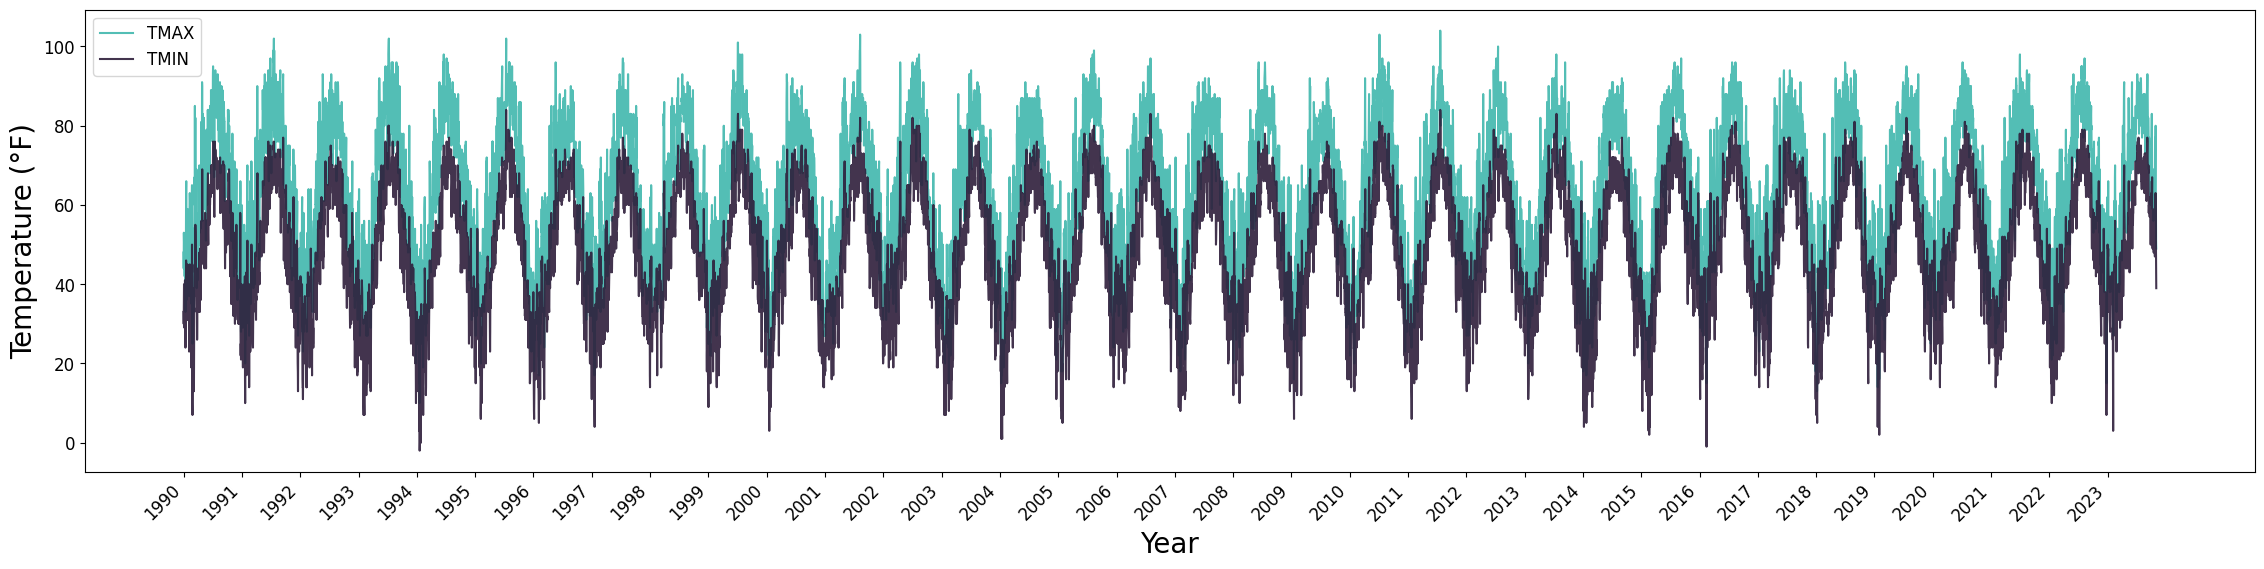

In [ ]:
# violet = '#7b5aa6'
# gray = '#6d6d6d'
palette = sns.color_palette("mako_r", 6)

fontsize = 20
interval = nyc_daily.shape[0]
years_txt, years = np.unique(nyc_daily.year, return_index = True)


fig_overall, ax = plt.subplots(1,1, figsize = (28,6))
sns.lineplot(x = nyc_daily.index[:interval], y = nyc_daily['TMAX'][:interval],
              color = palette[1], label = 'TMAX', alpha = 0.9)
sns.lineplot(x = nyc_daily.index[:interval], y = nyc_daily['TMIN'][:interval],
              color = palette[-1], label = 'TMIN', alpha = 0.9)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_xticks(years)
ax.set_xticklabels(years_txt, rotation = 45, ha= 'right')
ax.tick_params(axis = 'y', labelsize = 12)
ax.tick_params(axis = 'x', labelsize = 12)
ax.set_ylabel('Temperature (°F)', fontsize = fontsize)
ax.set_xlabel('Year', fontsize = fontsize, labelpad = 5.0)

ax.legend(fontsize = 12)
plt.show()
# we see clear cyclic pattern

##### Ithaca hourly

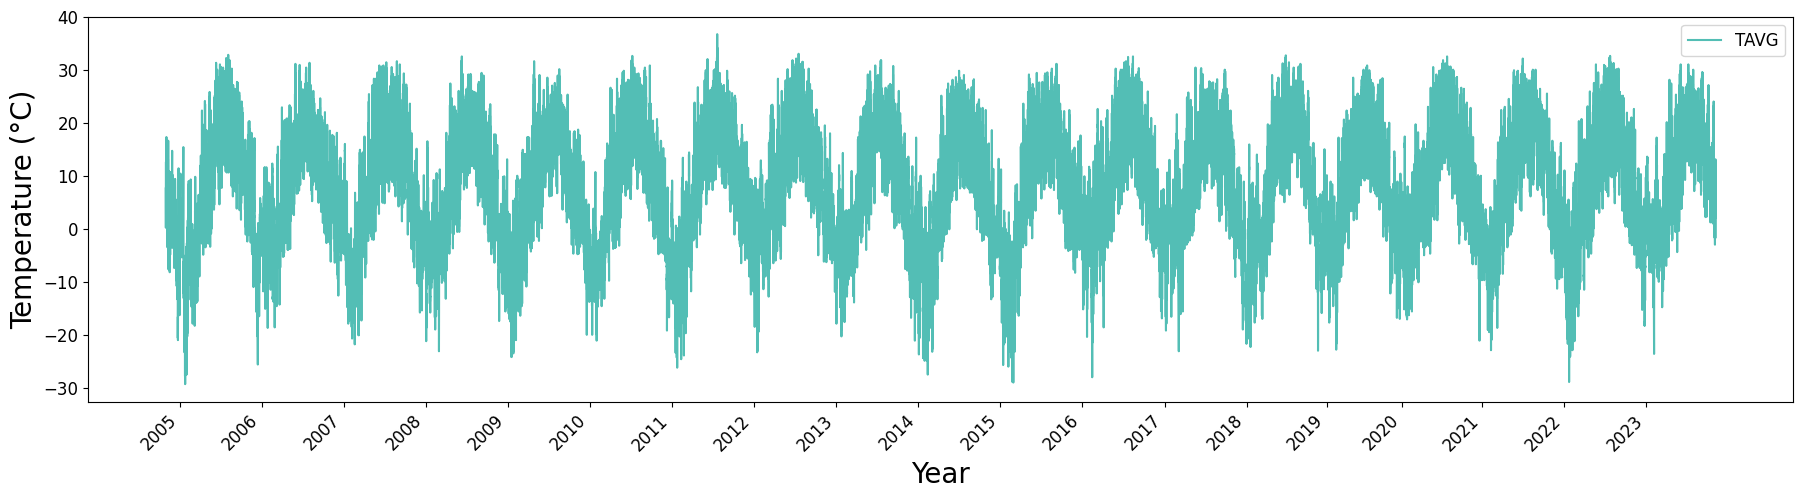

In [ ]:
# violet = '#7b5aa6'
# gray = '#6d6d6d'
palette = sns.color_palette("mako_r", 6)

fontsize = 20
interval = Ithaca_hourly.shape[0]
# find beginning of each year, used for xtick labels
years_txt, years = np.unique(Ithaca_hourly.Time.dt.year, return_index = True)

fig_overall, ax = plt.subplots(1,1, figsize = (22,5))
sns.lineplot(x = Ithaca_hourly.index[:interval], y = Ithaca_hourly['T_HR_AVG'][:interval],
              color = palette[1], label = 'TAVG', alpha = 0.9)
ax.set_xticklabels([])
ax.set_xticks(years[1:]) # 2004 collapsed...
ax.set_xticklabels(years_txt[1:], rotation = 45, ha= 'right')
ax.tick_params(axis = 'y', labelsize = 12)
ax.tick_params(axis = 'x', labelsize = 12)
ax.set_ylabel('Temperature (°C)', fontsize = fontsize)
ax.set_xlabel('Year', fontsize = fontsize, labelpad = 5.0)
ax.legend(fontsize = 12)
plt.show()
# we see clear cyclic pattern
# Hourly plot is more noisy. but I think both work.

##### Ithaca Daily

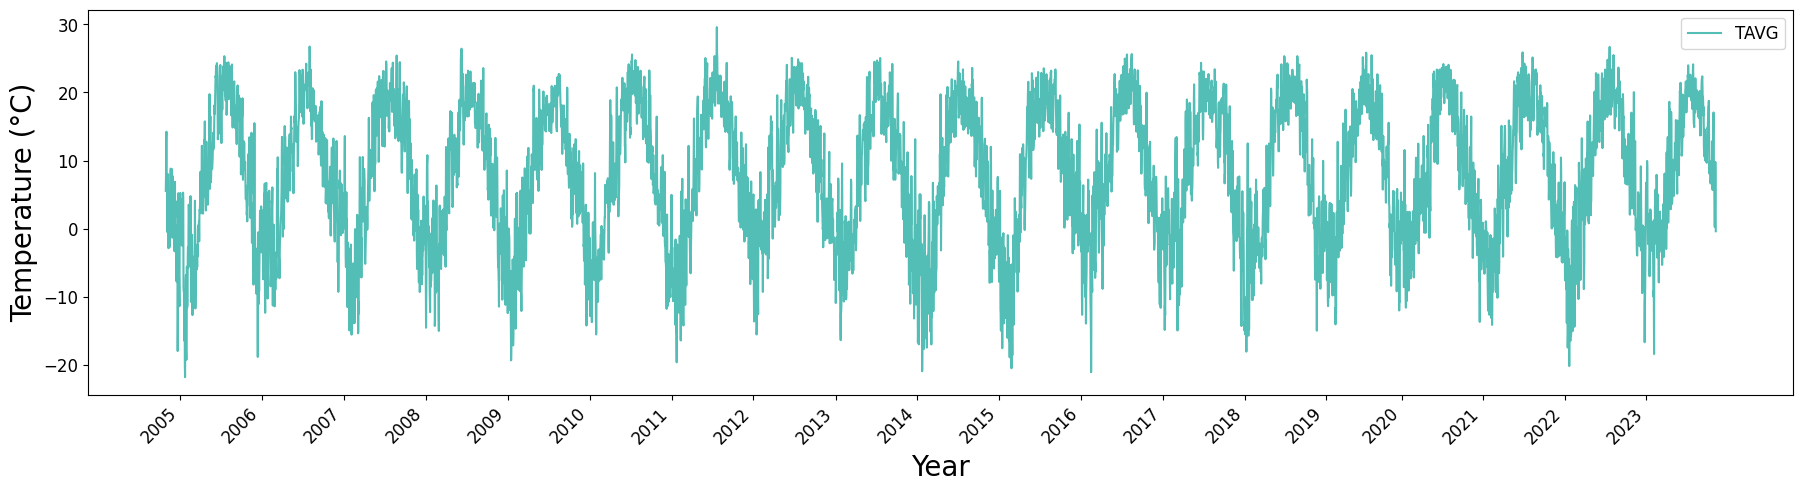

In [ ]:
# violet = '#7b5aa6'
# gray = '#6d6d6d'
palette = sns.color_palette("mako_r", 6)

fontsize = 20
interval = Ithaca_daily.shape[0]
# find beginning of each year, used for xtick labels
years_txt, years = np.unique(Ithaca_daily.Time.dt.year, return_index = True)

fig_overall, ax = plt.subplots(1,1, figsize = (22,5))
sns.lineplot(x = Ithaca_daily.index[:interval], y = Ithaca_daily['T_AVG'][:interval],
              color = palette[1], label = 'TAVG', alpha = 0.9)
ax.set_xticklabels([])
ax.set_xticks(years[1:]) # 2004 collapsed...
ax.set_xticklabels(years_txt[1:], rotation = 45, ha= 'right')
ax.tick_params(axis = 'y', labelsize = 12)
ax.tick_params(axis = 'x', labelsize = 12)
ax.set_ylabel('Temperature (°C)', fontsize = fontsize)
ax.set_xlabel('Year', fontsize = fontsize, labelpad = 5.0)
ax.legend(fontsize = 12)
plt.show()

### Initial Model

#### 0. train val split

In [ ]:
### train val split: ~ 8:2
Ithaca_hourly_train = Ithaca_hourly[Ithaca_hourly.Time.dt.year < 2020]
Ithaca_hourly_val = Ithaca_hourly[Ithaca_hourly.Time.dt.year >=2020]
print(f'training set length = {Ithaca_hourly_train.shape[0]}\n val set length = {Ithaca_hourly_val.shape[0]}')

training set length = 131871
 val set length = 33442


#### 1. look at ACF, PACF, run KPSS, ADF test for stationarity

In [ ]:
### Determine dependence order by plotting ACF
n_lags_ar = 365*24*10
n_lags_ma = 365
acf_sm = acf(Ithaca_hourly_train.T_HR_AVG, nlags = n_lags_ar)
pacf_sm = pacf(Ithaca_hourly_train.T_HR_AVG, nlags = n_lags_ma)

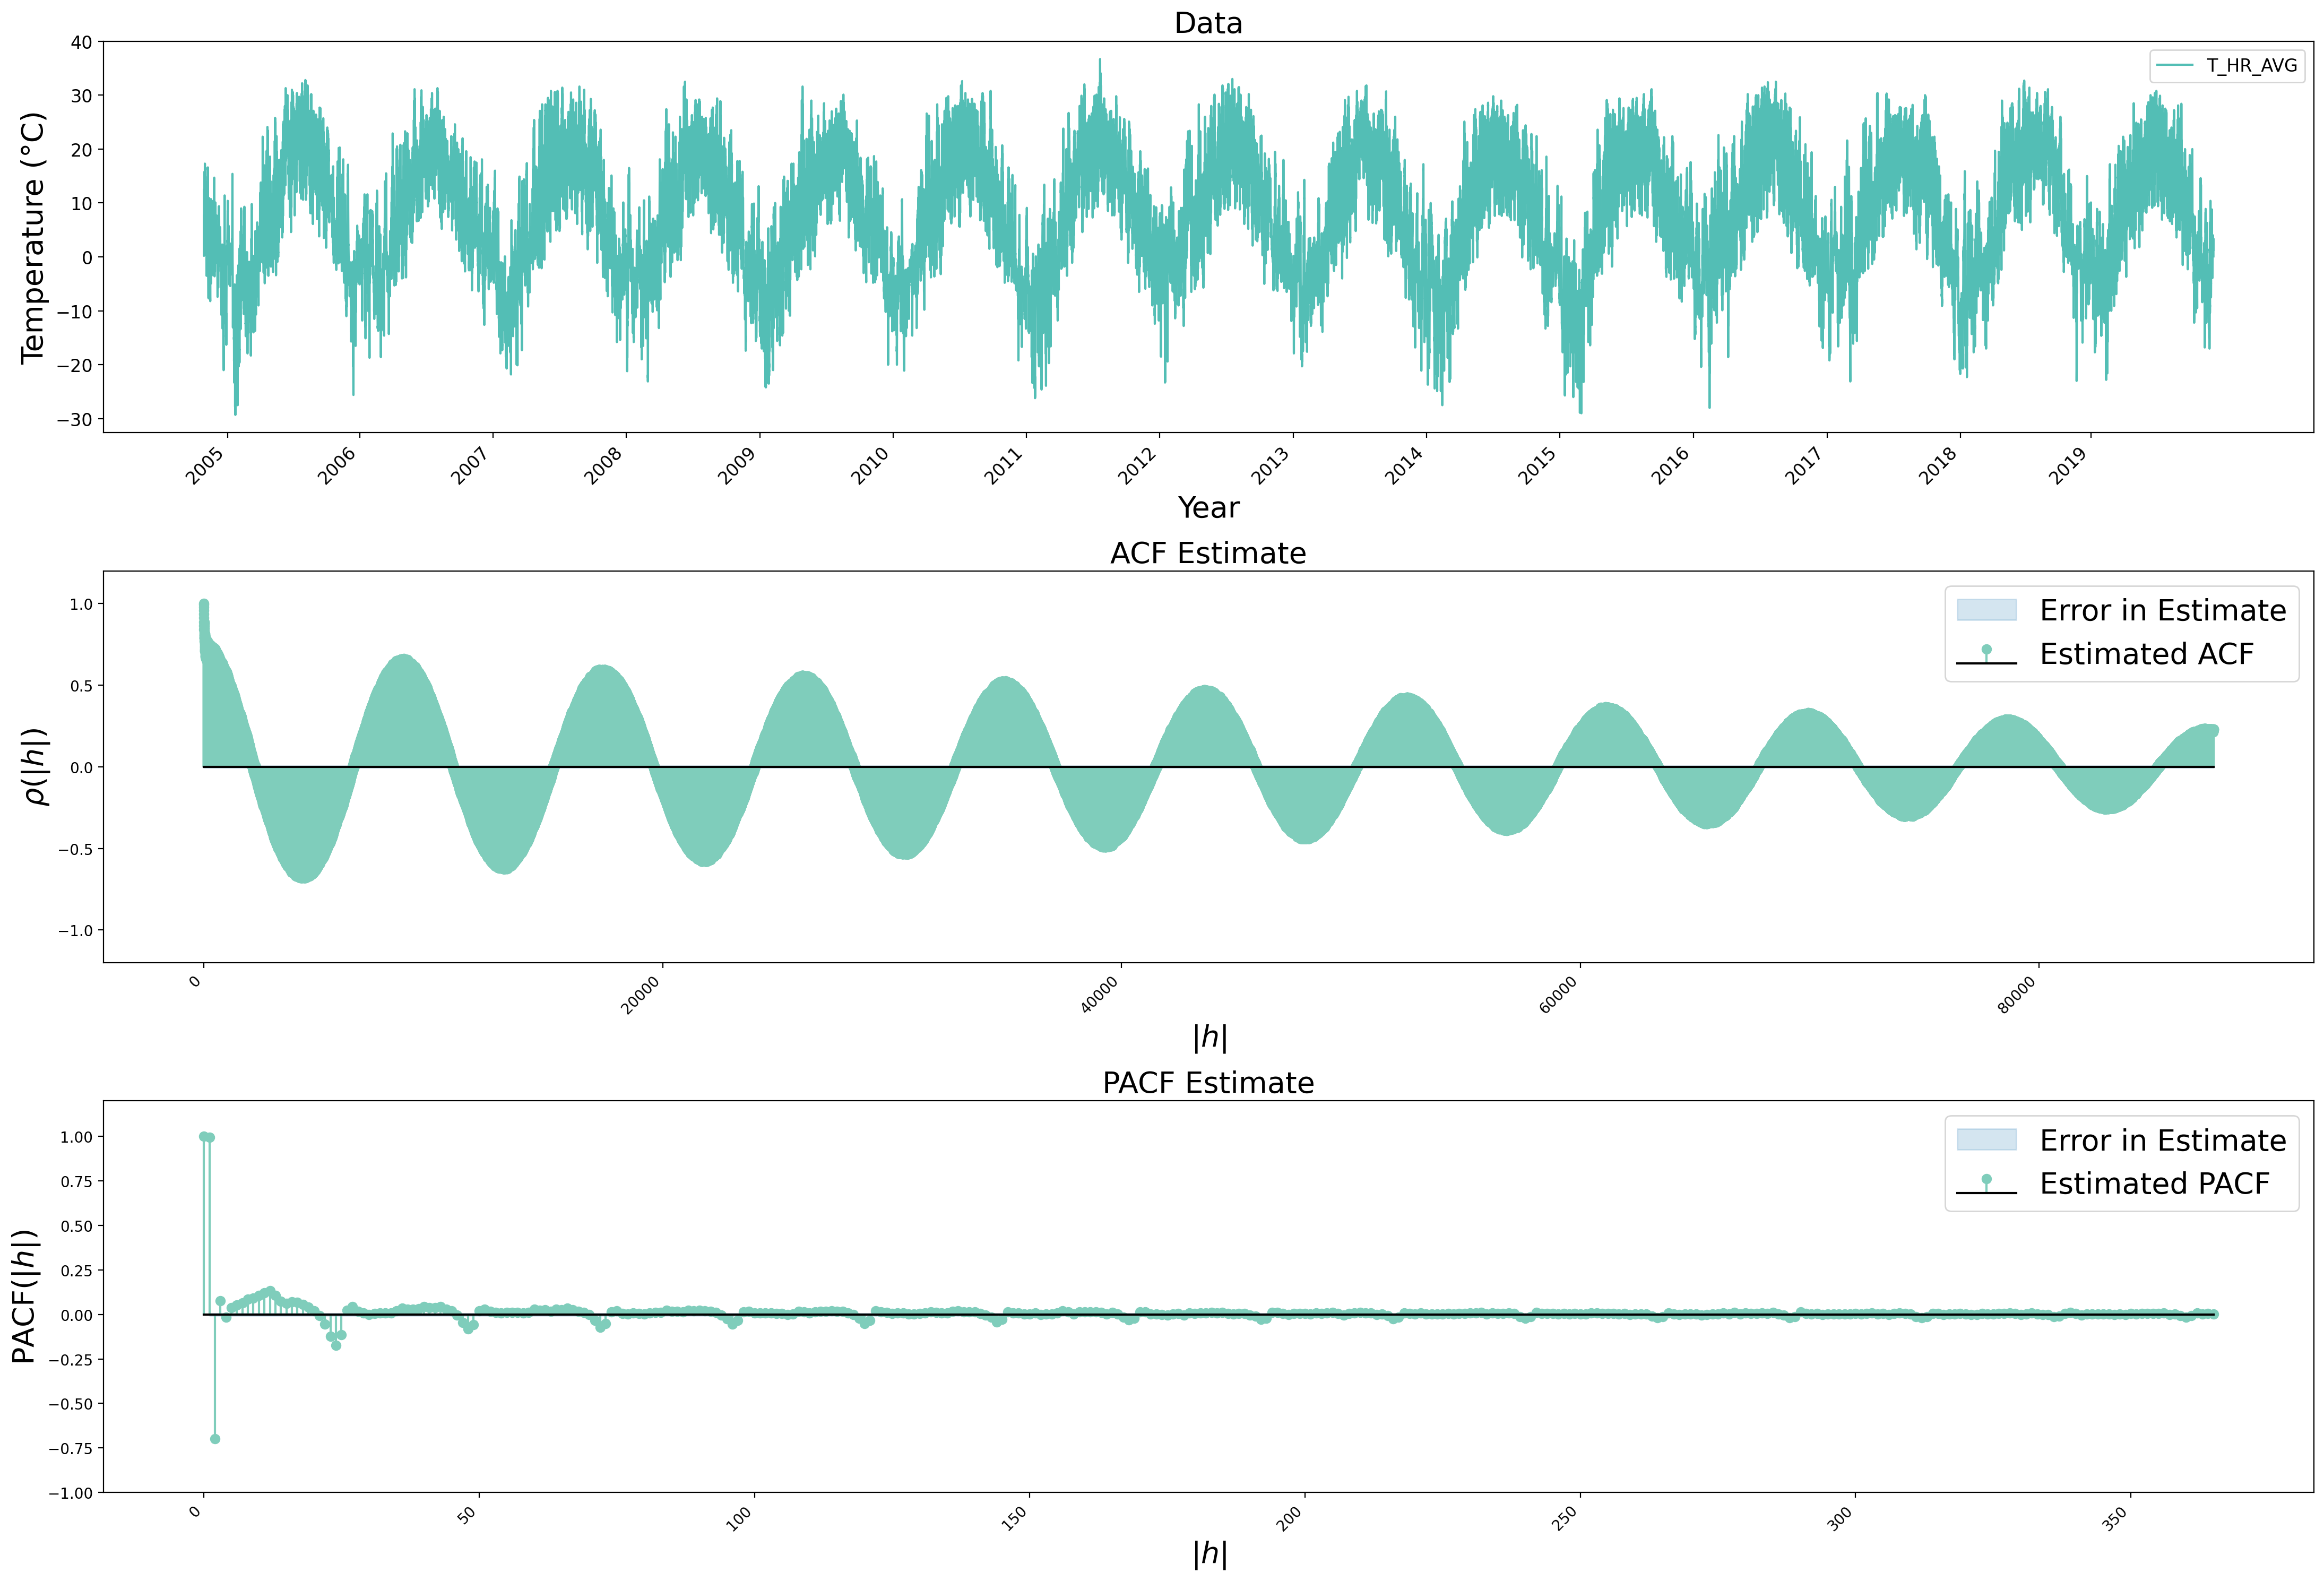

In [ ]:
### Plot
plot_triple(Ithaca_hourly_train, n_lags_ar, n_lags_ma, acf_sm, pacf_sm, col = 'T_HR_AVG', fig_name = 'raw_data')

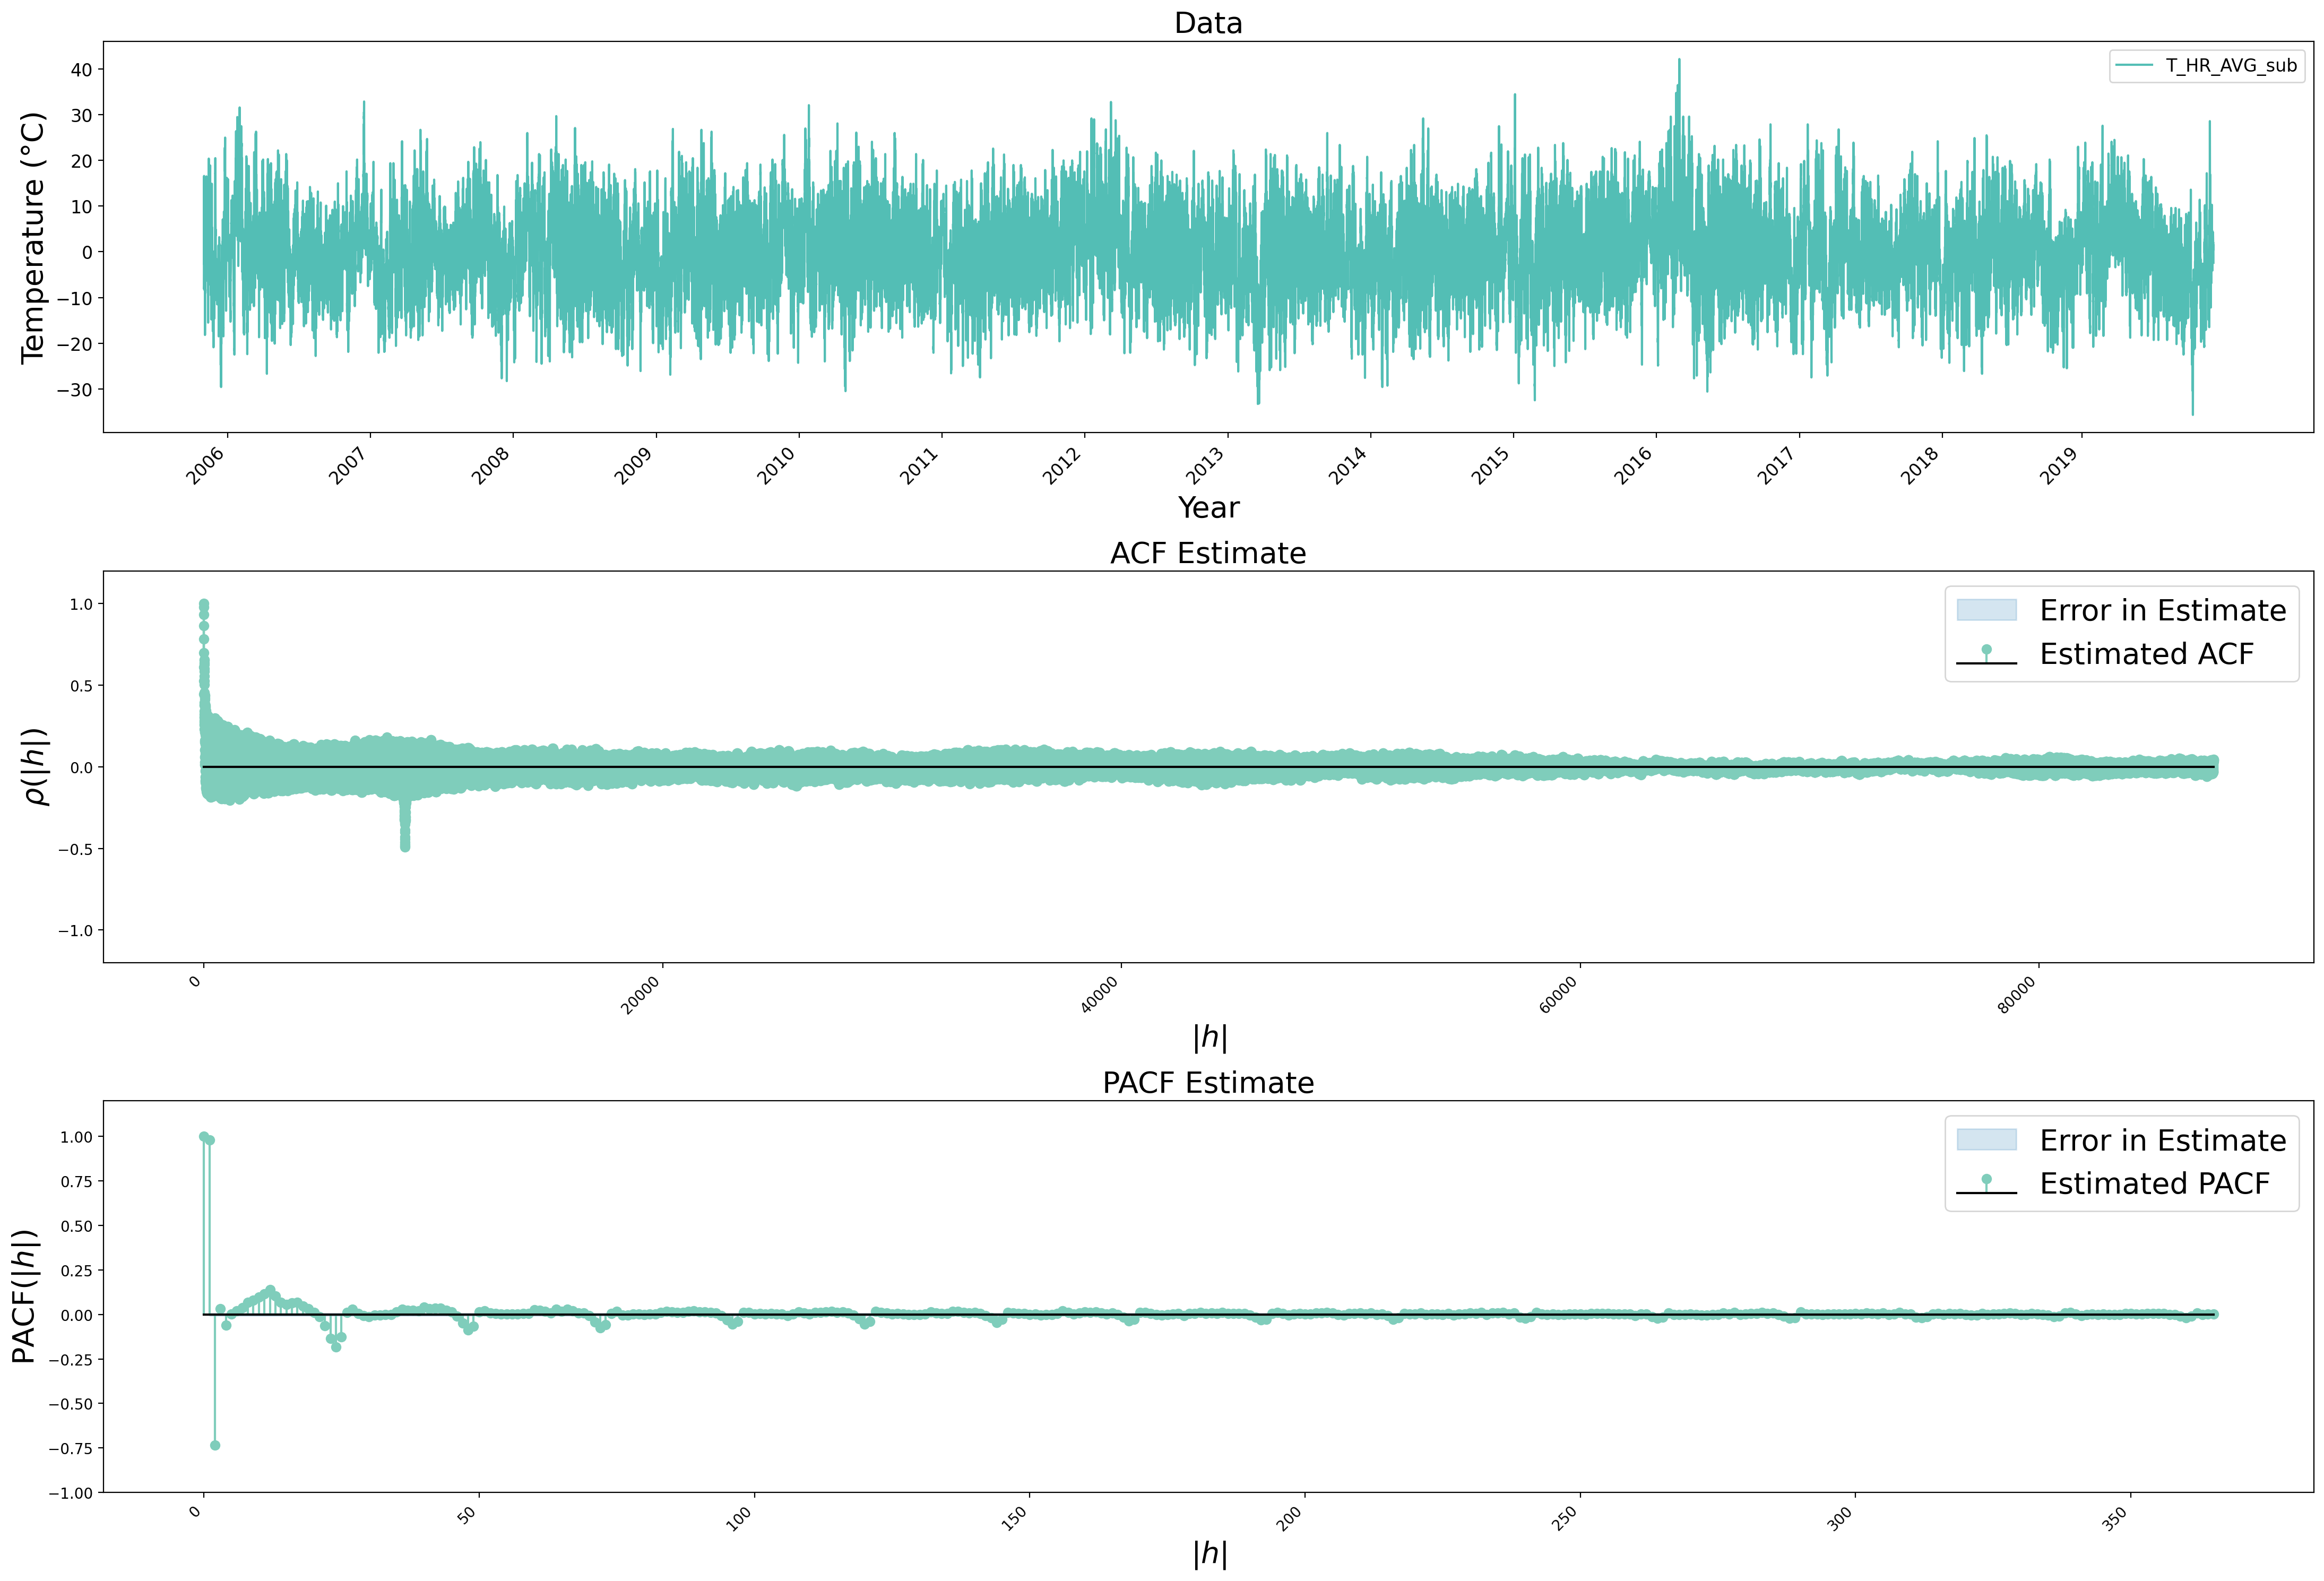

In [ ]:
### plot without seasonality
# suggest seasonality of 356*24 = 8760
# let's remove seasonality by subtraction, as per pts4
seasonality = 8760
Ithaca_hourly_train_no_season = Ithaca_hourly_train.join(pd.DataFrame(Ithaca_hourly_train.T_HR_AVG.diff(seasonality).dropna()),
                                             how = 'right', rsuffix = '_sub').reset_index()
n_lags_ar = 365*24*10
n_lags_ma = 365
acf_no_season_sm = acf(Ithaca_hourly_train_no_season.T_HR_AVG_sub, nlags = n_lags_ar)
pacf_no_season_sm = pacf(Ithaca_hourly_train_no_season.T_HR_AVG_sub, nlags = n_lags_ma)

plot_triple(Ithaca_hourly_train_no_season, n_lags_ar, n_lags_ma, acf_sm = acf_no_season_sm,
            pacf_sm = pacf_no_season_sm, col = 'T_HR_AVG_sub', fig_name = 'drop_seasonality')

In [ ]:
### check stationarity
adfuller(Ithaca_hourly_train_no_season.T_HR_AVG_sub) # seem to be stationary

(-29.73253901386185,
 0.0,
 72,
 123038,
 {'1%': -3.4304031497296332,
  '5%': -2.861563491396274,
  '10%': -2.5667825036397725},
 365694.86750573805)

#### 2. Deal with P, Q (seasonal AR & MA), as per [pts4](http://www.stat.ucla.edu/~frederic/221/W21/tsa4.pdf)
- Seems to lead to more satisfactory results if deal with seasonal first

In [ ]:
seasonality = 8760
# acf_seasonal = acf_no_season_sm[::seasonality]
# pacf_seasonal = pacf(Ithaca_hourly_train_no_season.T_HR_AVG_sub,  nlags = seasonality//10) # really computationally expensive

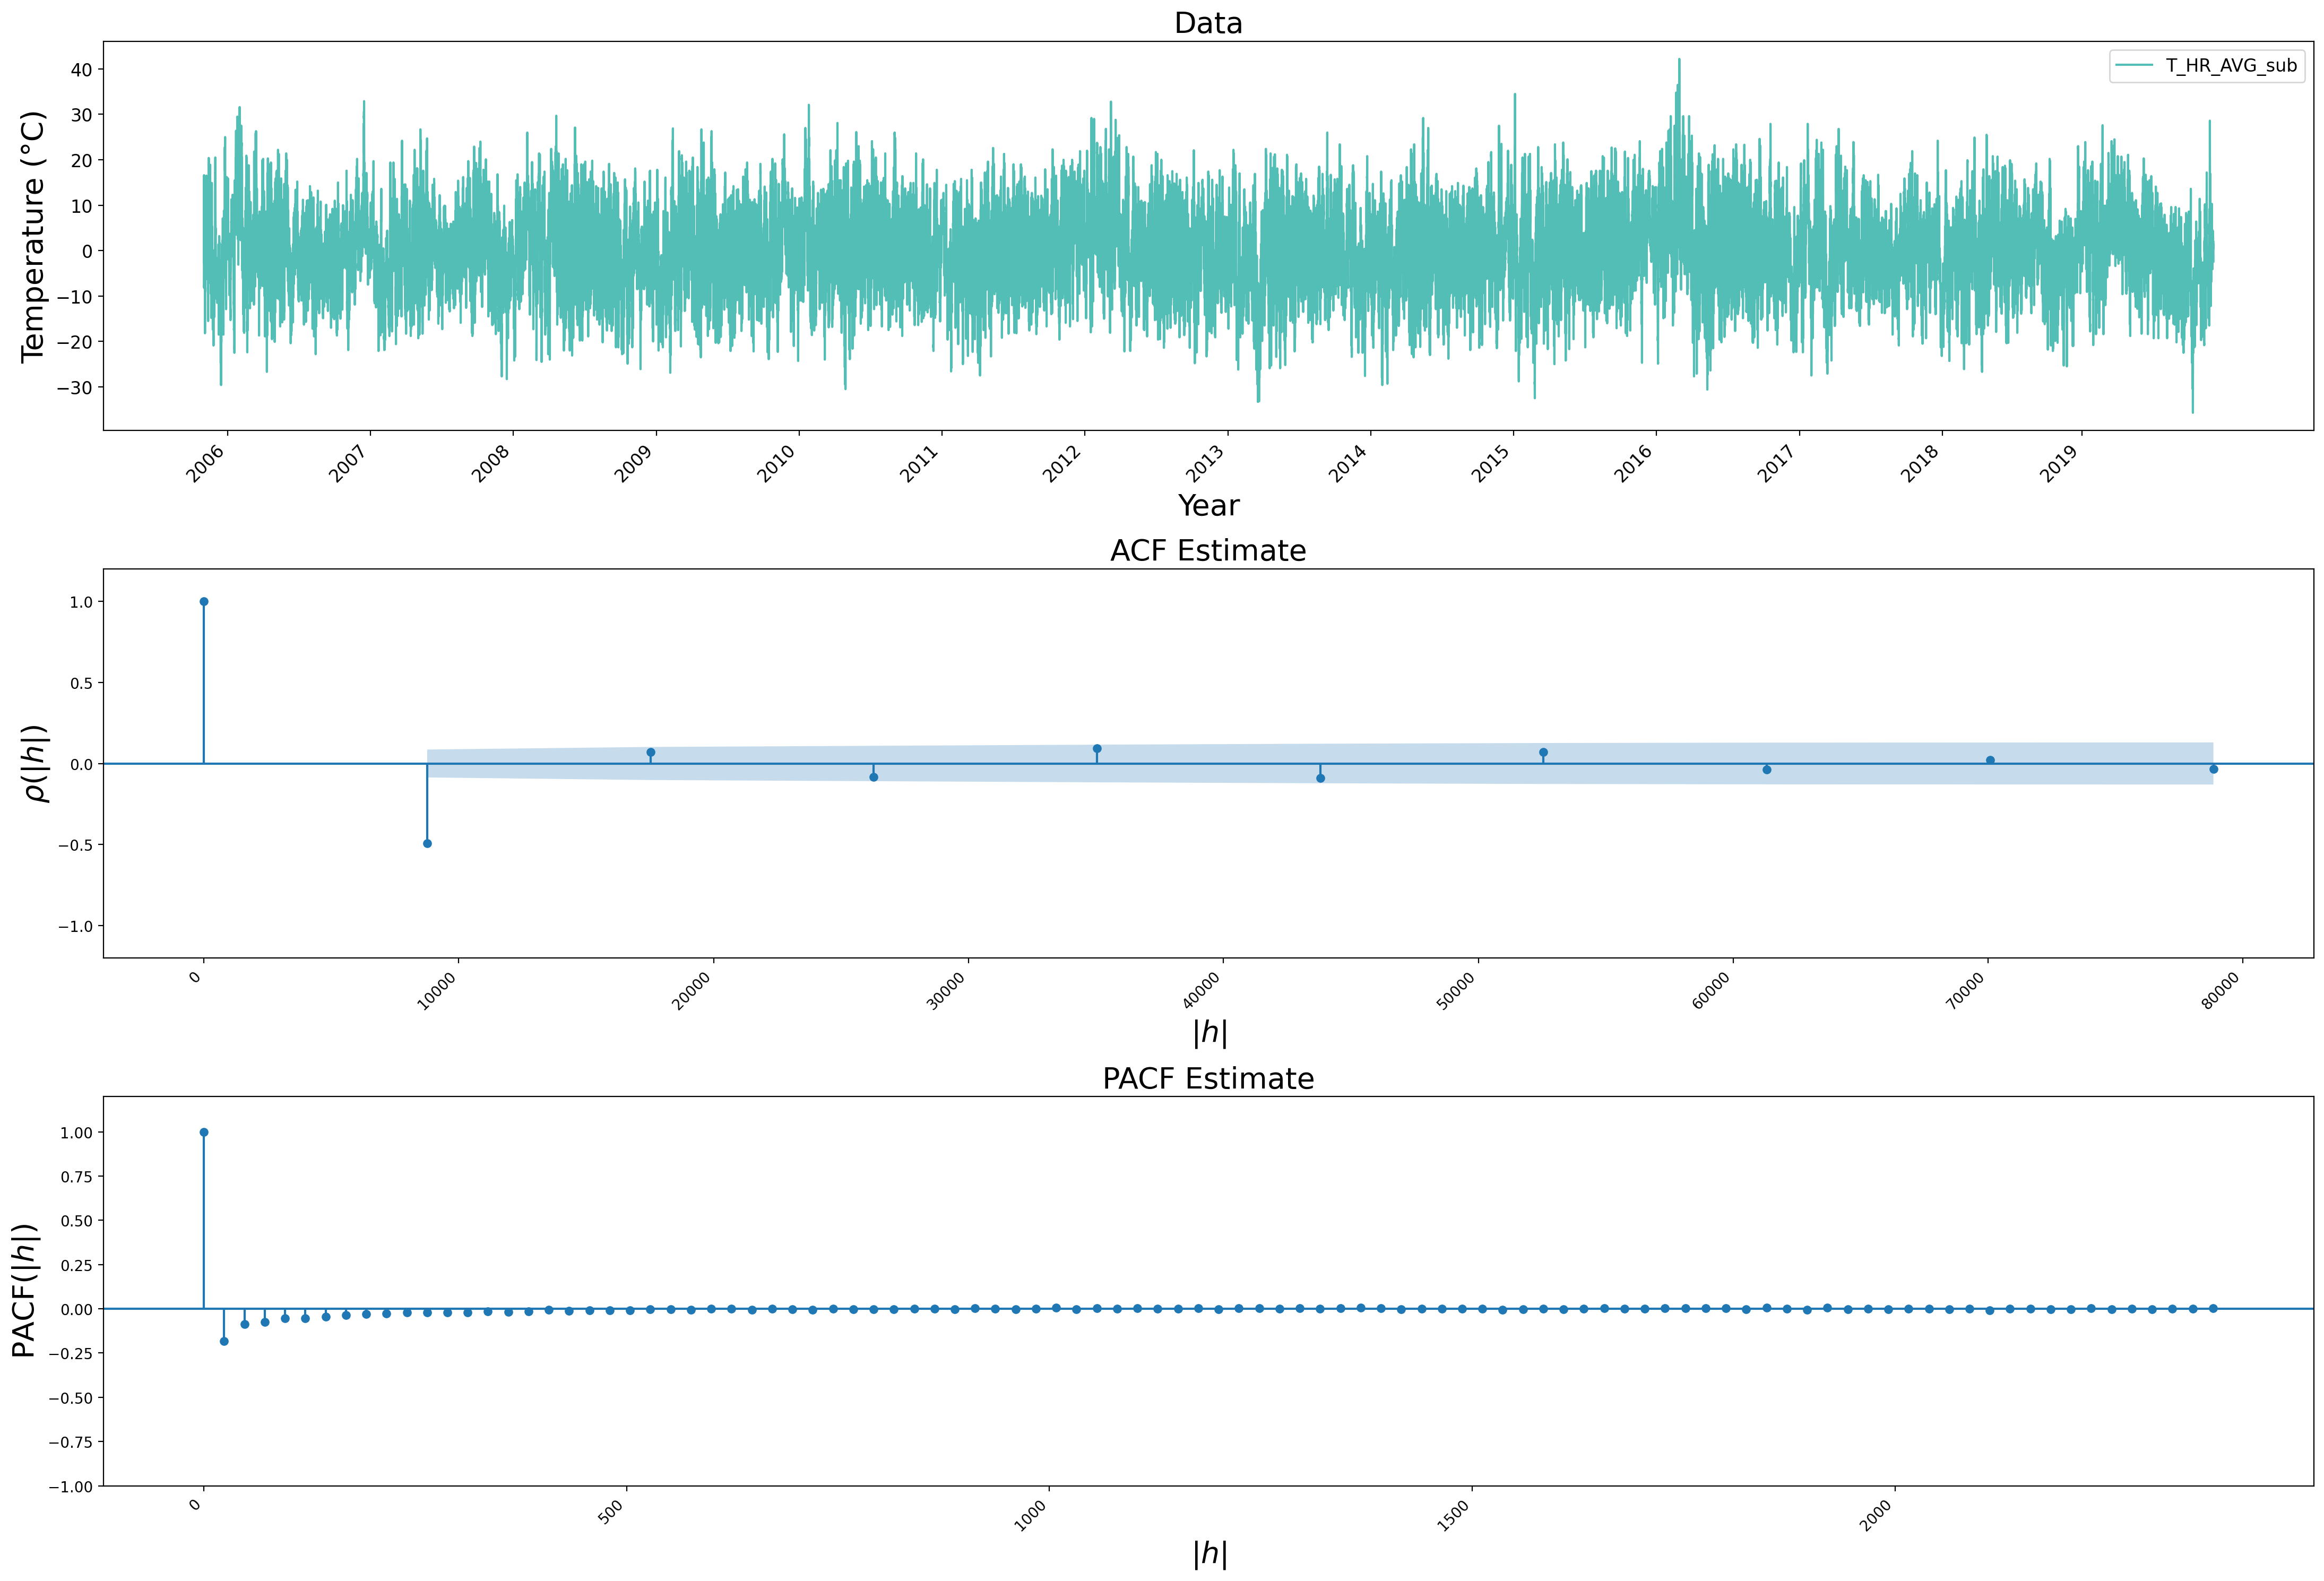

In [ ]:
## plot
plot_triple_built_in(df = Ithaca_hourly_train_no_season,
                     n_lags_ar = seasonality * 10, n_lags_ma = 24*100,
                     seasonality = seasonality,
                     col = 'T_HR_AVG_sub',fig_name = 'seasonal_P_Q')
# suggests Q <=1, but P? suggests 0 AR(P)? Let's just try it. Or take a look at daily?

##### 2.1 (side) take a look at daily TAVG to determine AR(P) (i.e., seasonal autoregressive process)

In [ ]:
Ithaca_daily_train = Ithaca_daily[Ithaca_daily.Time.dt.year < 2020]
Ithaca_daily_val = Ithaca_daily[Ithaca_daily.Time.dt.year >=2020]
print(f'training set length = {Ithaca_daily_train.shape[0]}\n val set length = {Ithaca_daily_val.shape[0]}')

training set length = 5510
 val set length = 1399


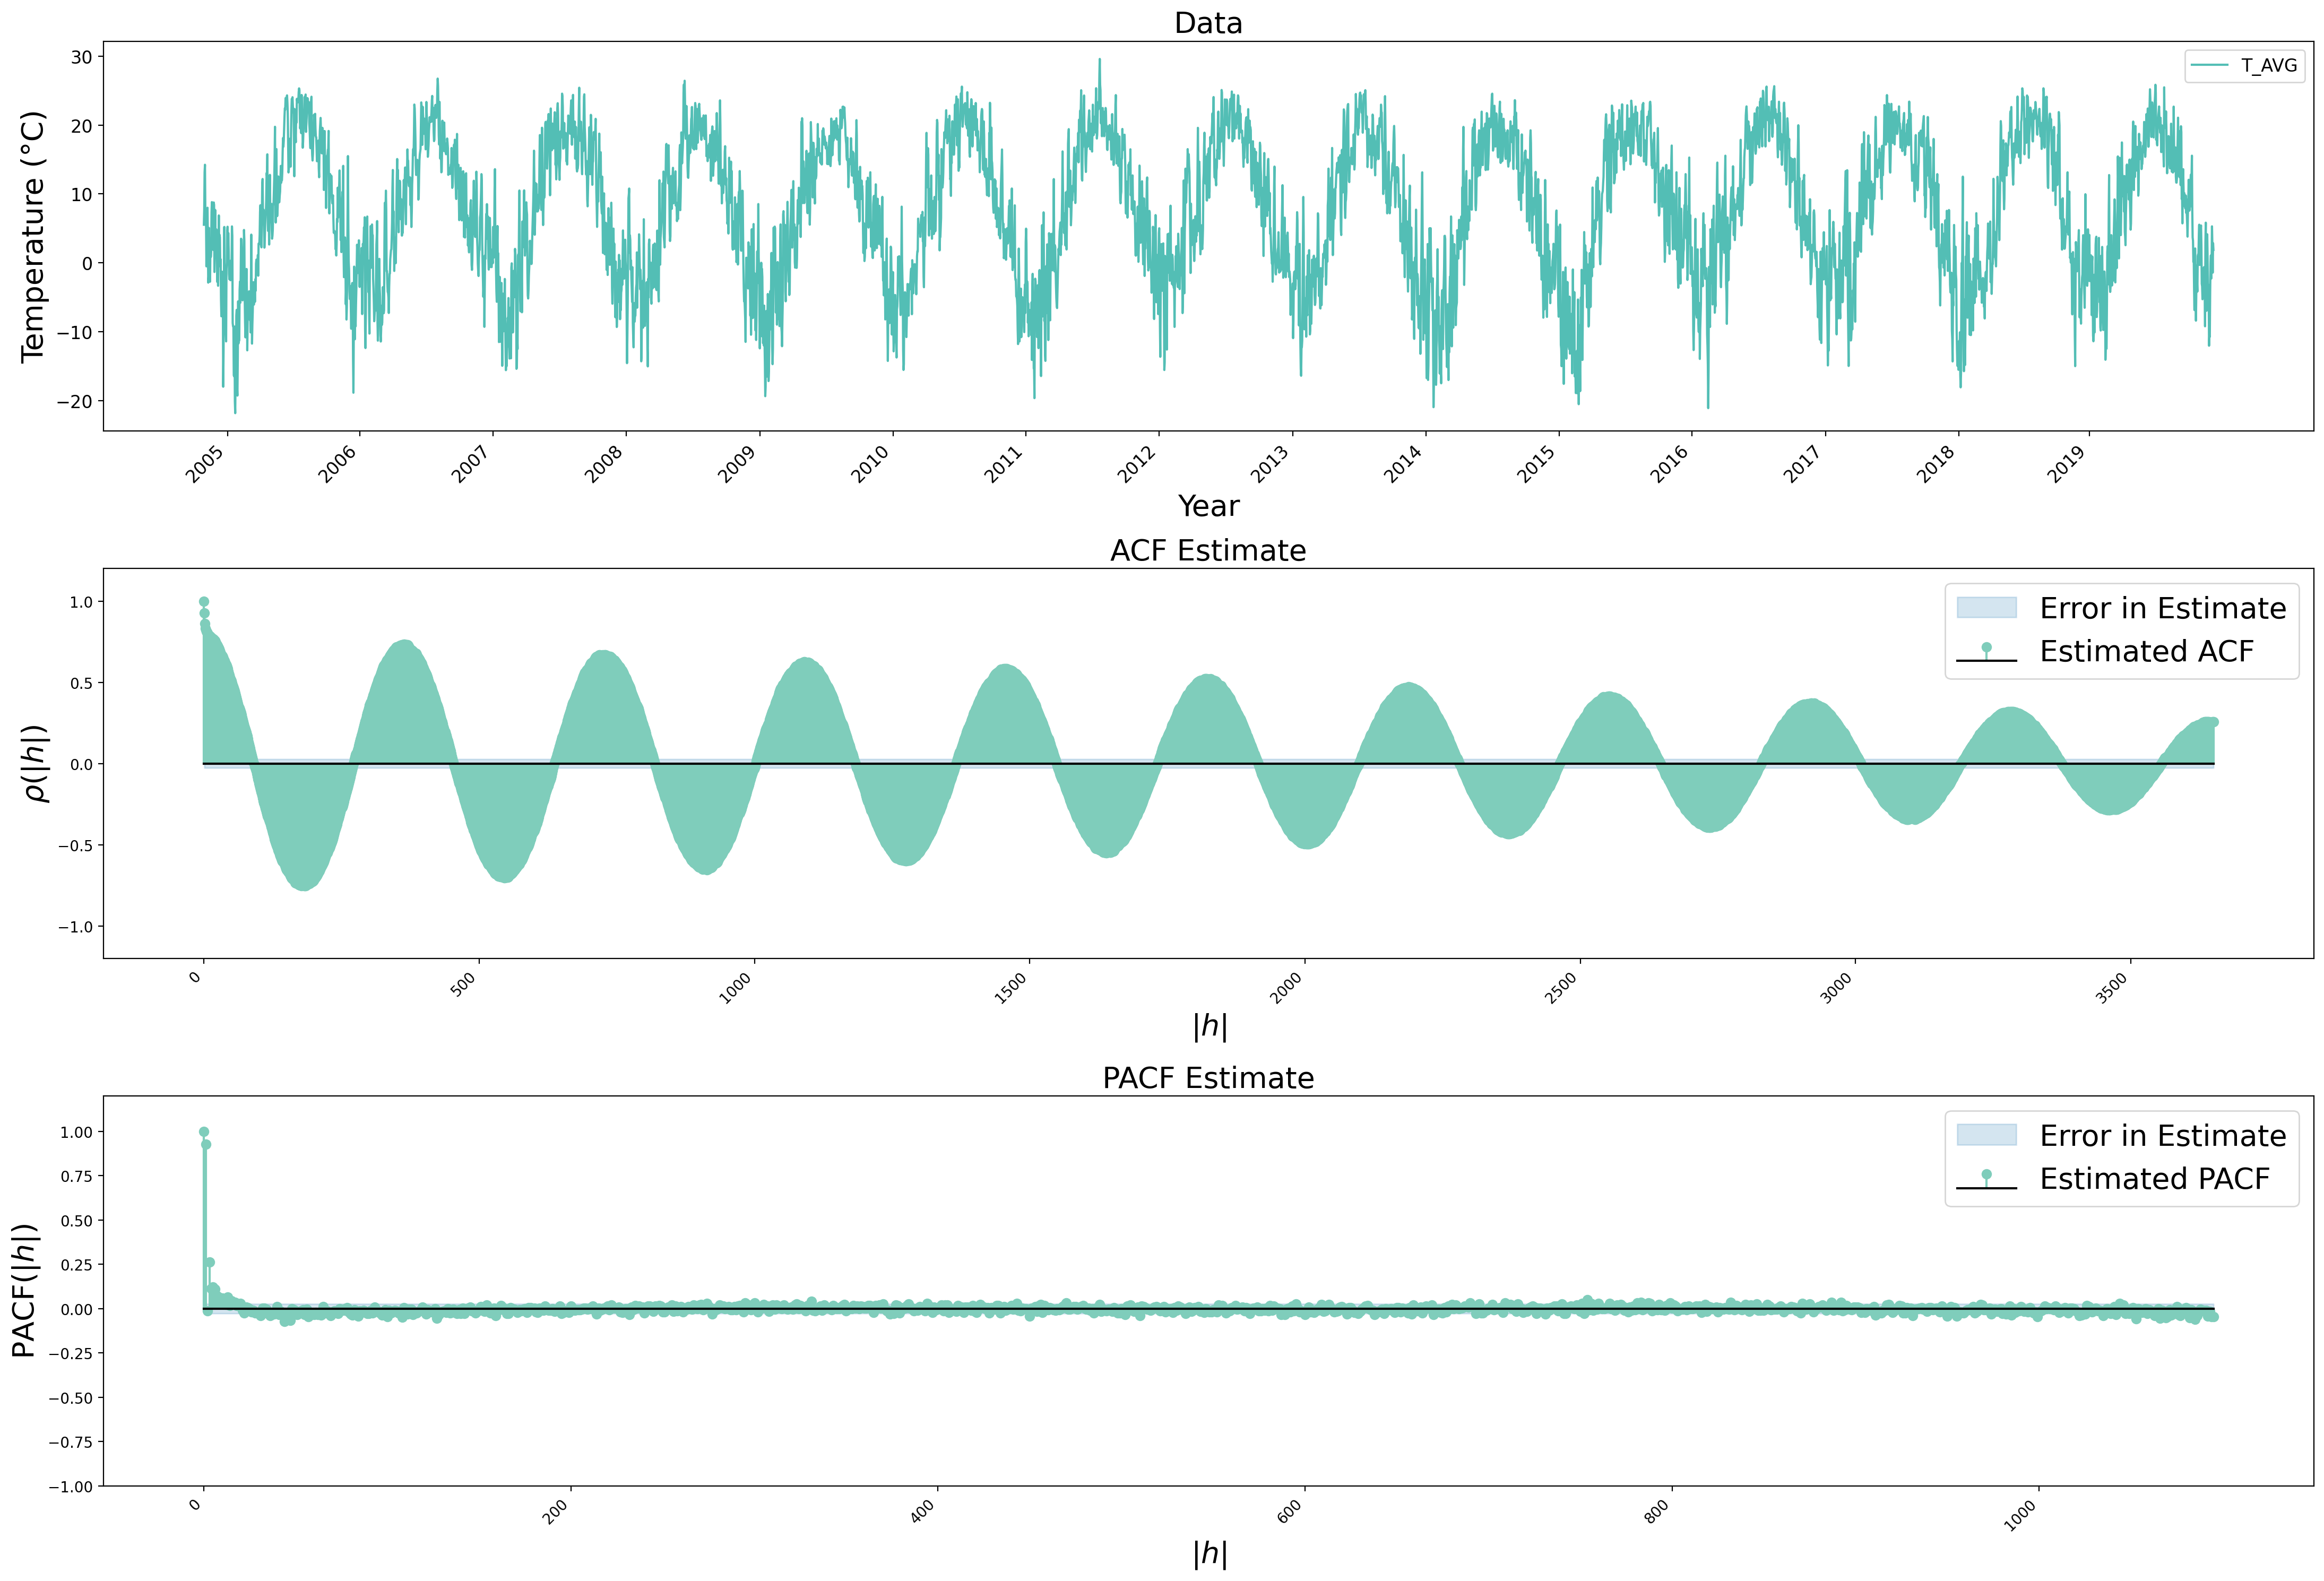

In [ ]:
n_lags_ar = 365*10
n_lags_ma = 365*3
acf_daily_sm = acf(Ithaca_daily_train.T_AVG, nlags = n_lags_ar)
pacf_daily_sm = pacf(Ithaca_daily_train.T_AVG, nlags = n_lags_ma)

plot_triple(Ithaca_daily_train, n_lags_ar, n_lags_ma, acf_sm = acf_daily_sm,
            pacf_sm = pacf_daily_sm, col = 'T_AVG', fig_name = 'Ithaca_daily_raw')

In [ ]:
seasonality = 365
Ithaca_daily_train_no_season = Ithaca_daily_train.join(pd.DataFrame(Ithaca_daily_train.T_AVG.diff(seasonality).dropna()),
                                             how = 'right', rsuffix = '_sub').reset_index()

adfuller(Ithaca_daily_train_no_season.T_AVG_sub) # seem to be stationary

(-11.624643547320348,
 2.339505390271266e-21,
 19,
 5125,
 {'1%': -3.4316266006519593,
  '5%': -2.862104122472345,
  '10%': -2.5670702825556218},
 30617.925638196415)

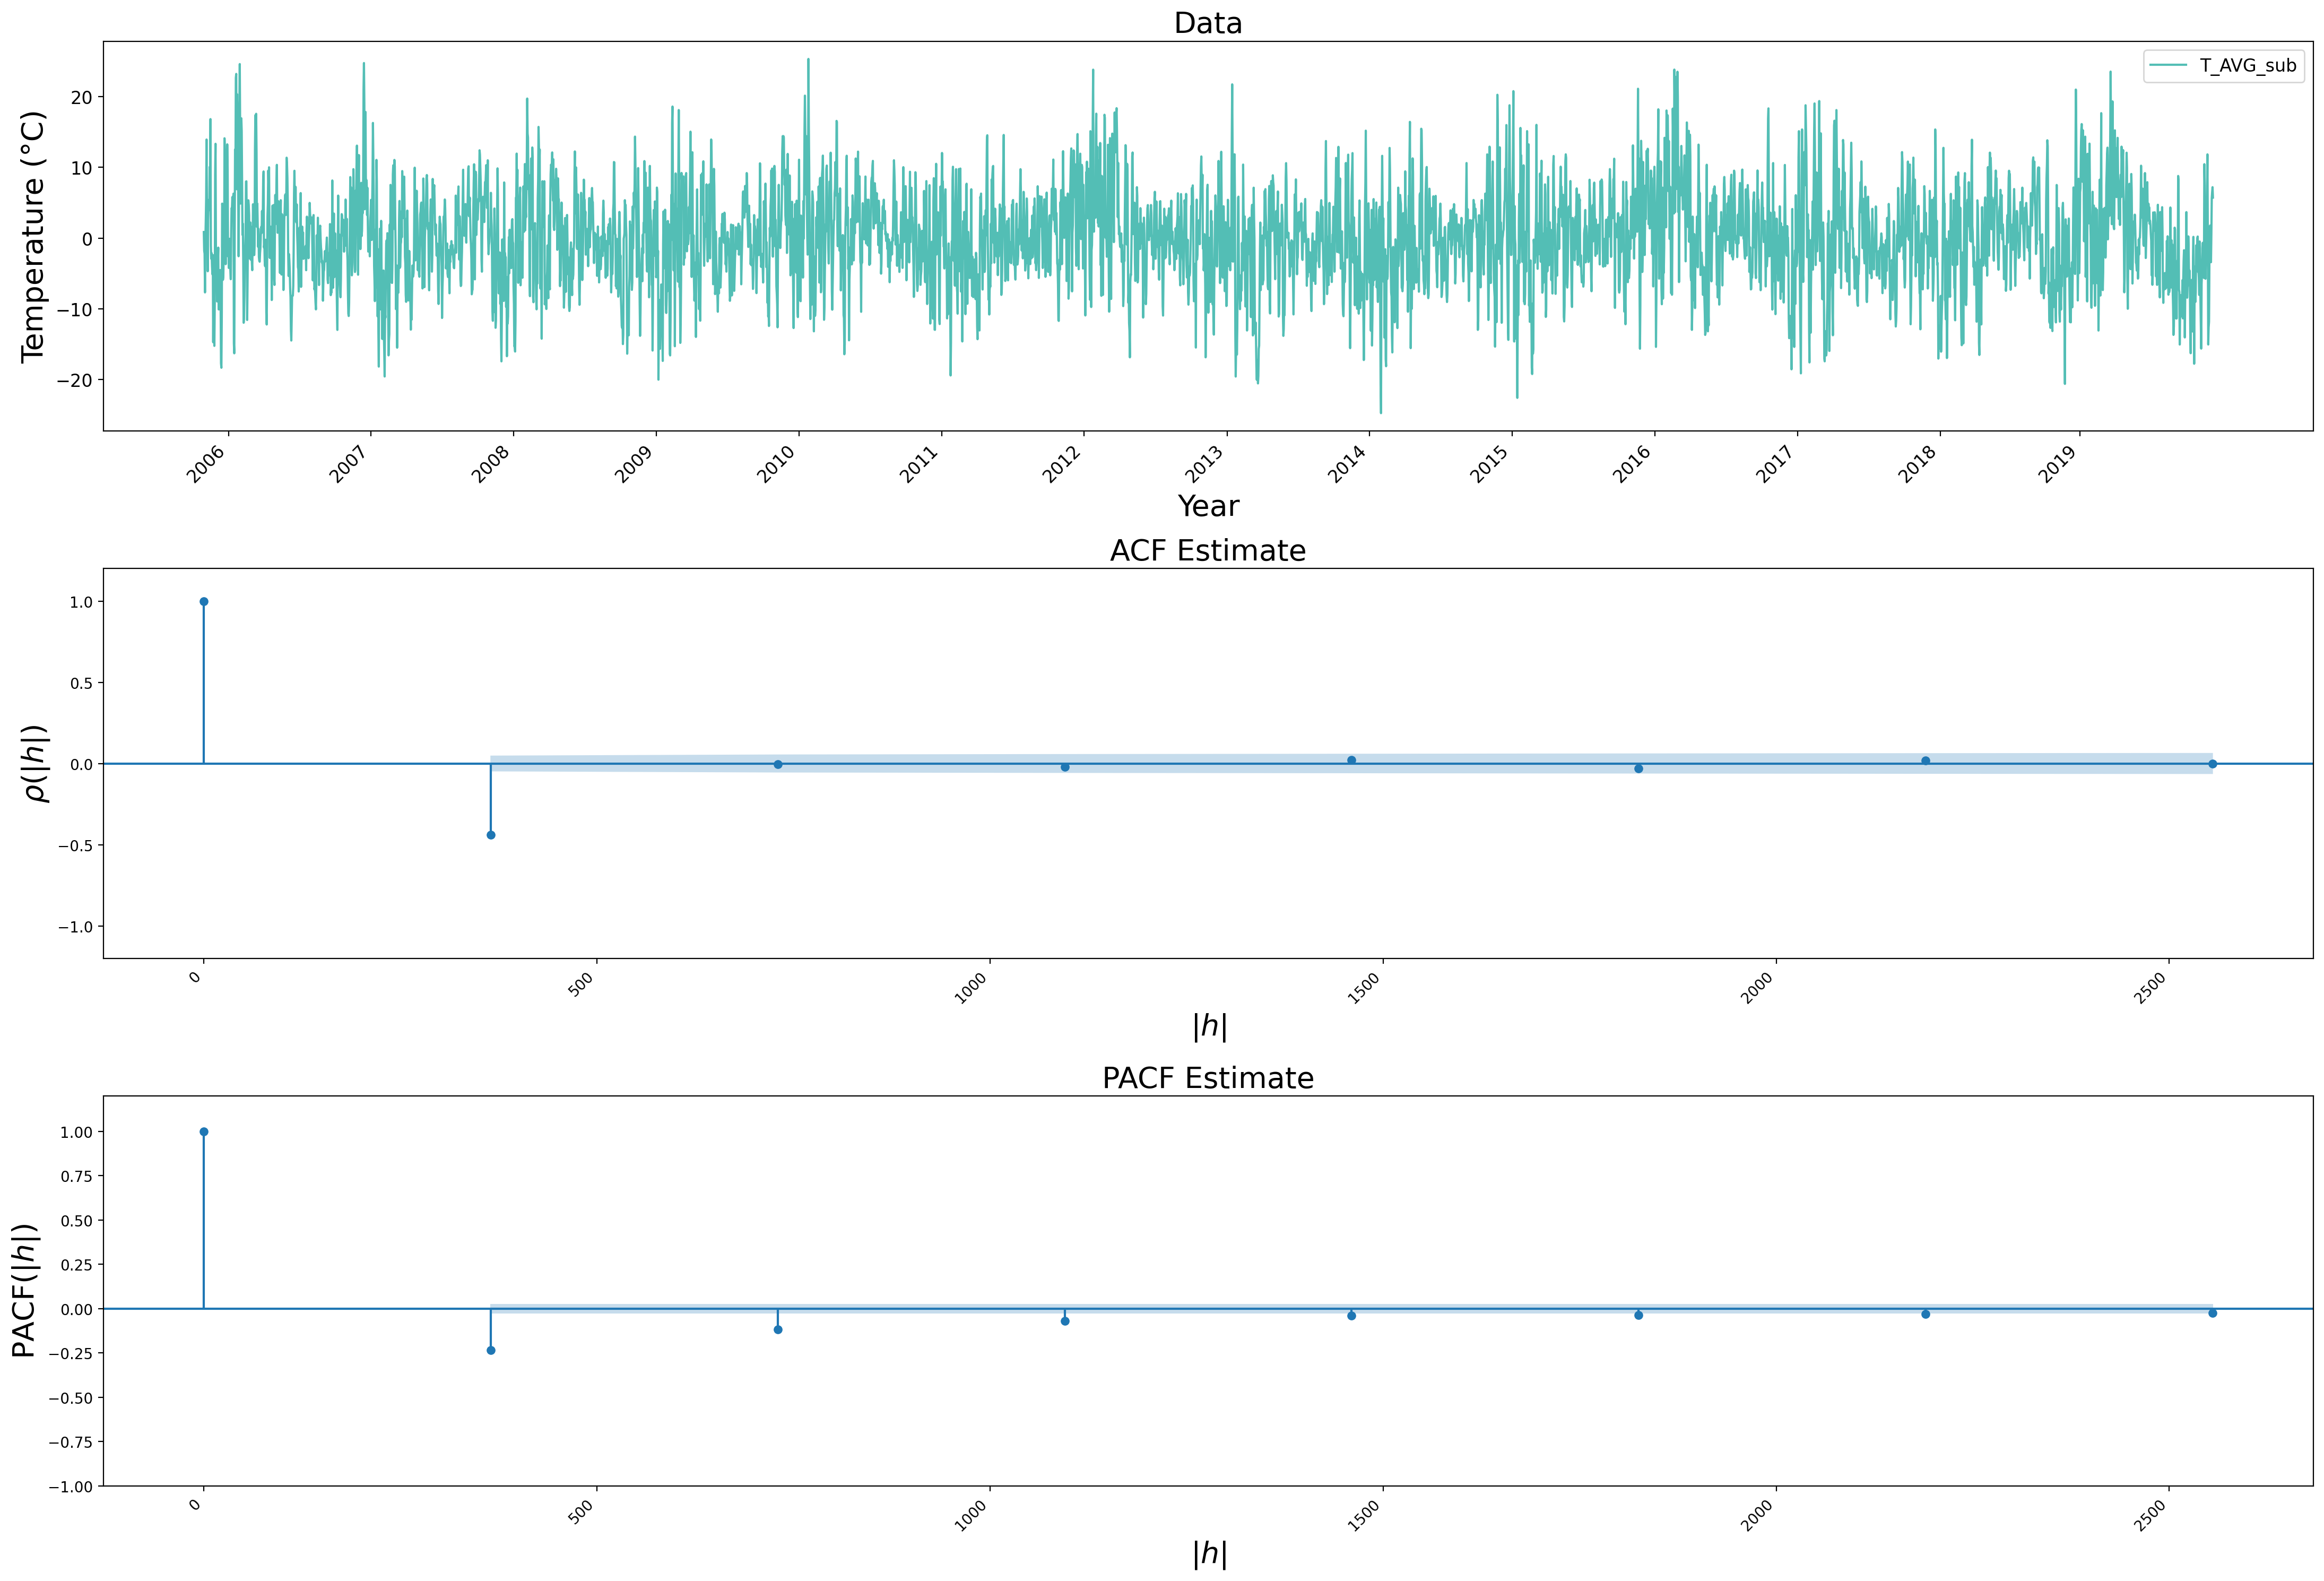

In [ ]:
## plot
plot_triple_built_in(df = Ithaca_daily_train_no_season,
                     n_lags_ar = seasonality * 8, n_lags_ma = seasonality * 8,
                     seasonality = seasonality, lag_ma = seasonality,
                     col = 'T_AVG_sub',fig_name = 'daily_p_q')

# daily plot suggests Q <=1 & P <= 3, reducing our search space.

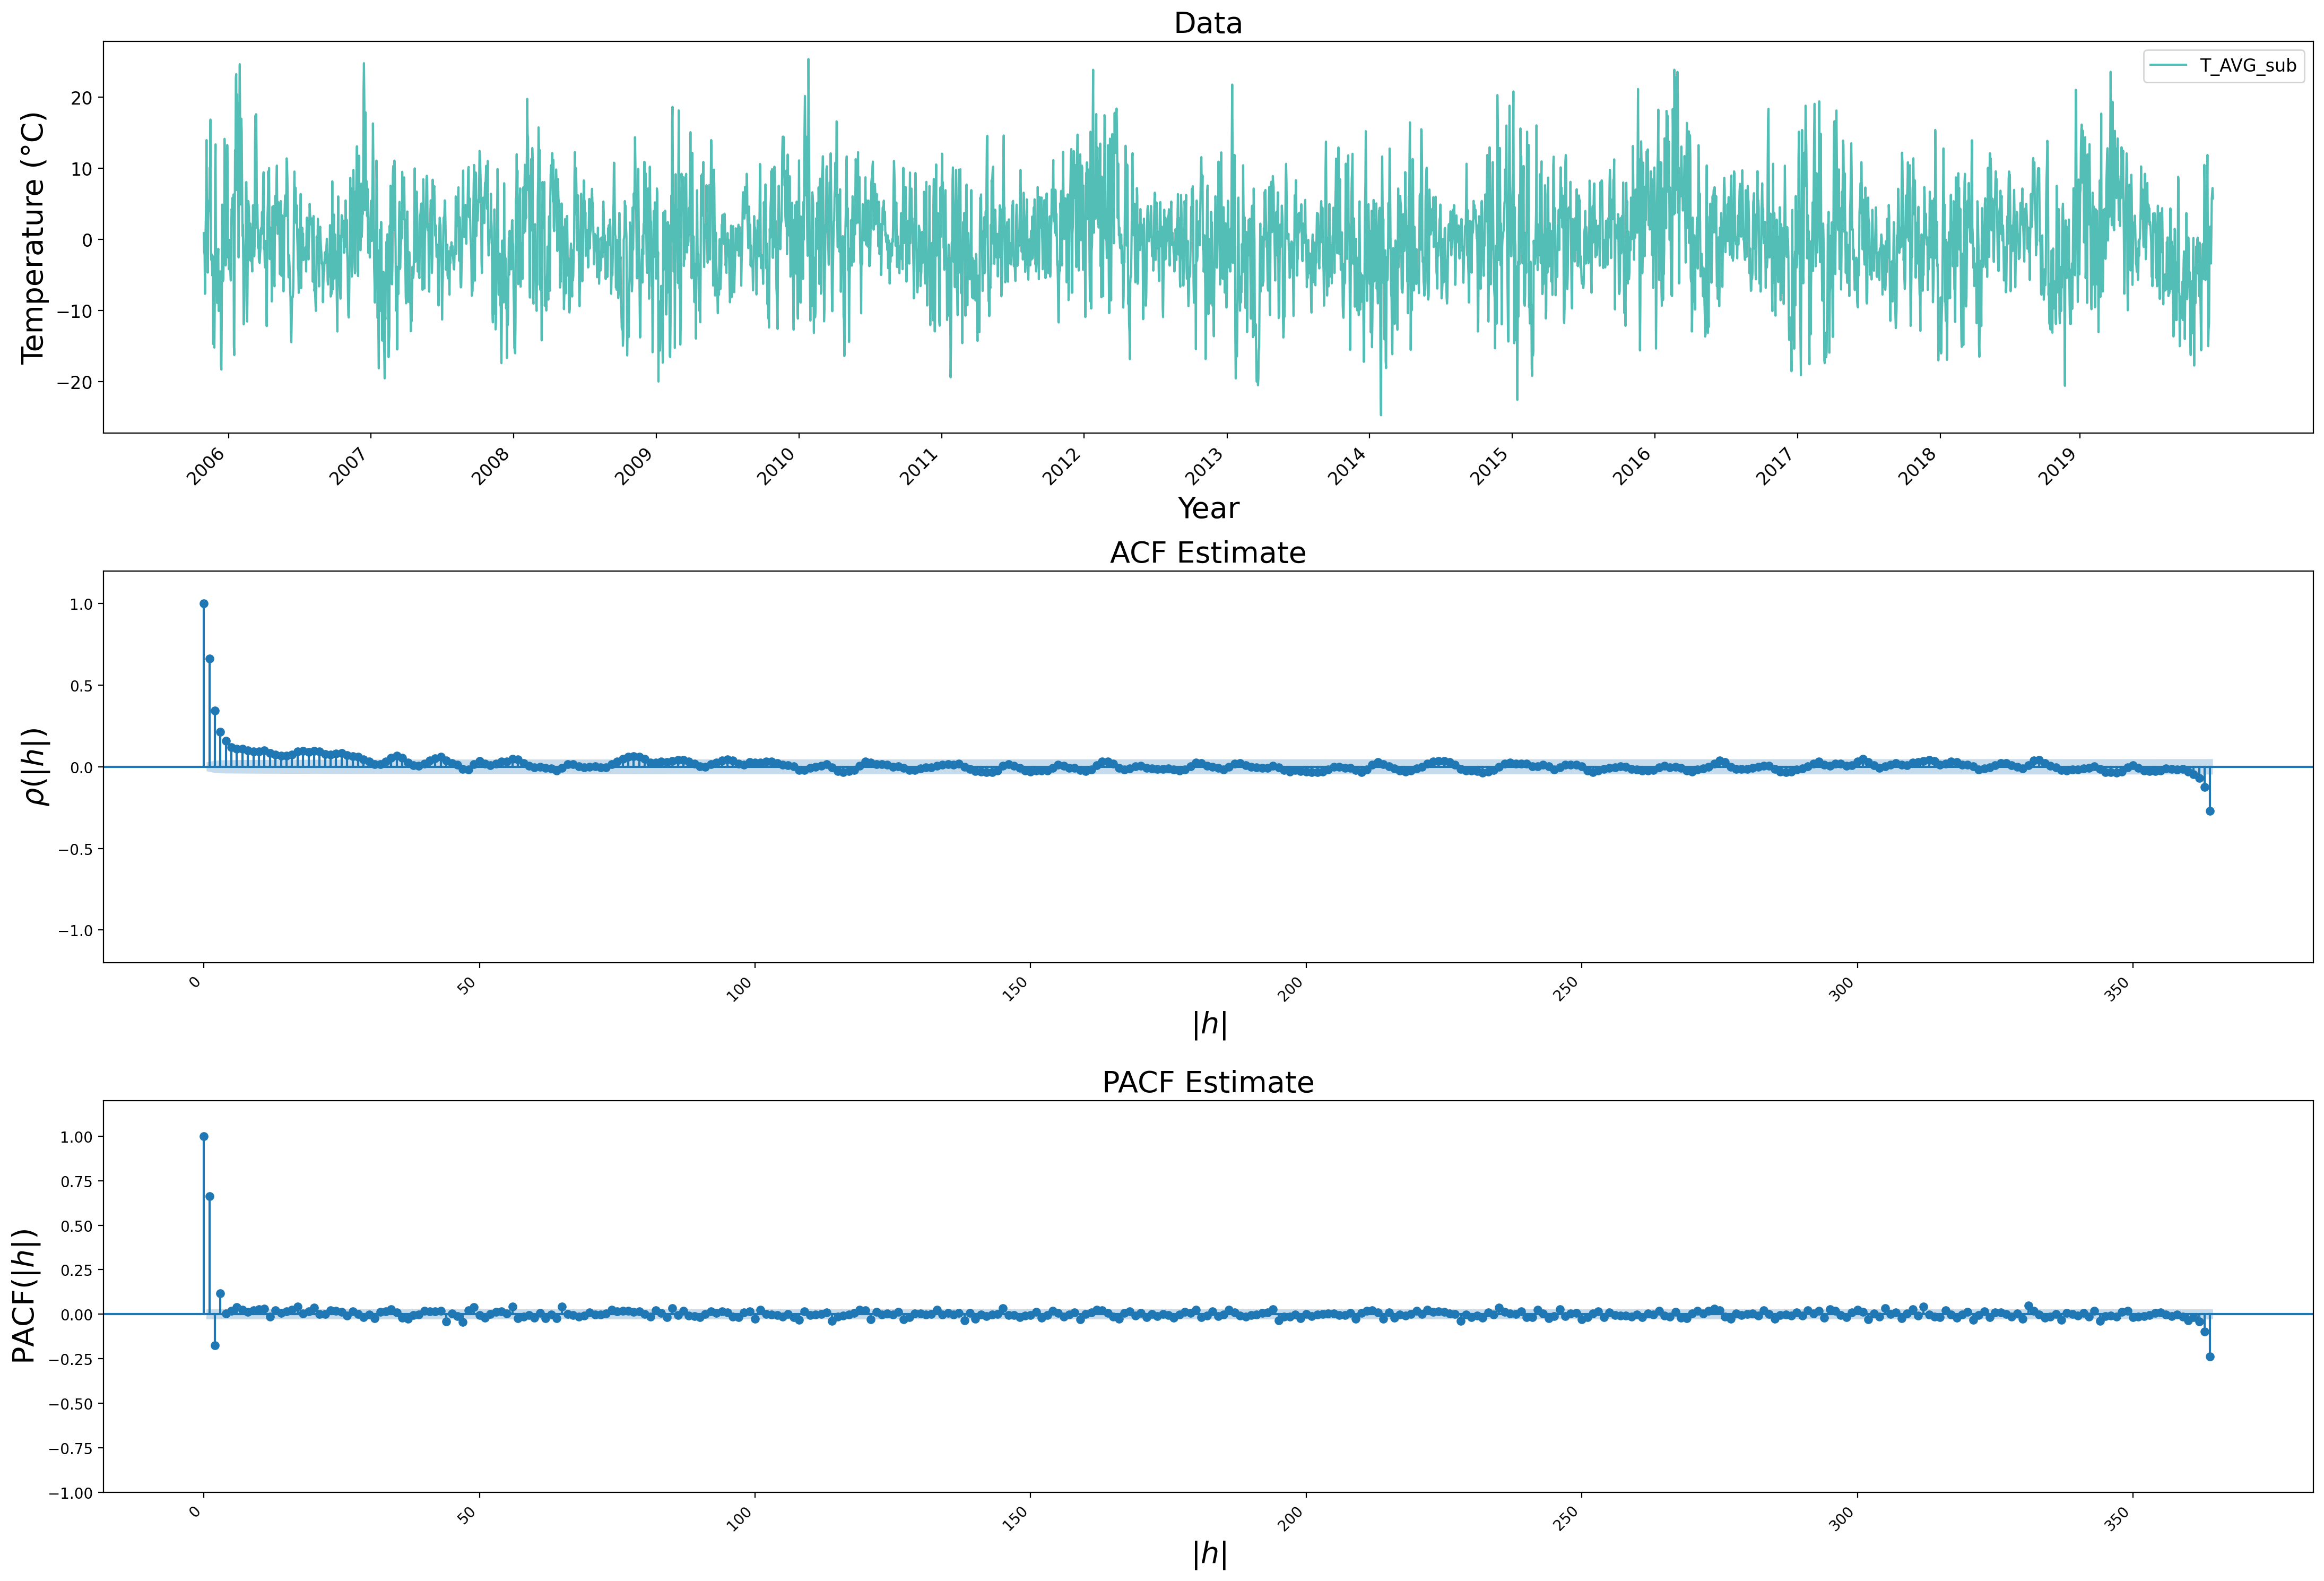

In [64]:
## Let's also draw acf & pacf in one cycle
plot_triple_built_in(df = Ithaca_daily_train_no_season,
                     n_lags_ar = seasonality, n_lags_ma = seasonality,
                     seasonality = 1, lag_ma = 1,
                     col = 'T_AVG_sub',fig_name = 'daily_seasonal_P_Q')
## suggest MA(q): q<=26/7? AR(p): p<=3?

array([0, 1, 2, 3, 4])

#### Back to hourly model:

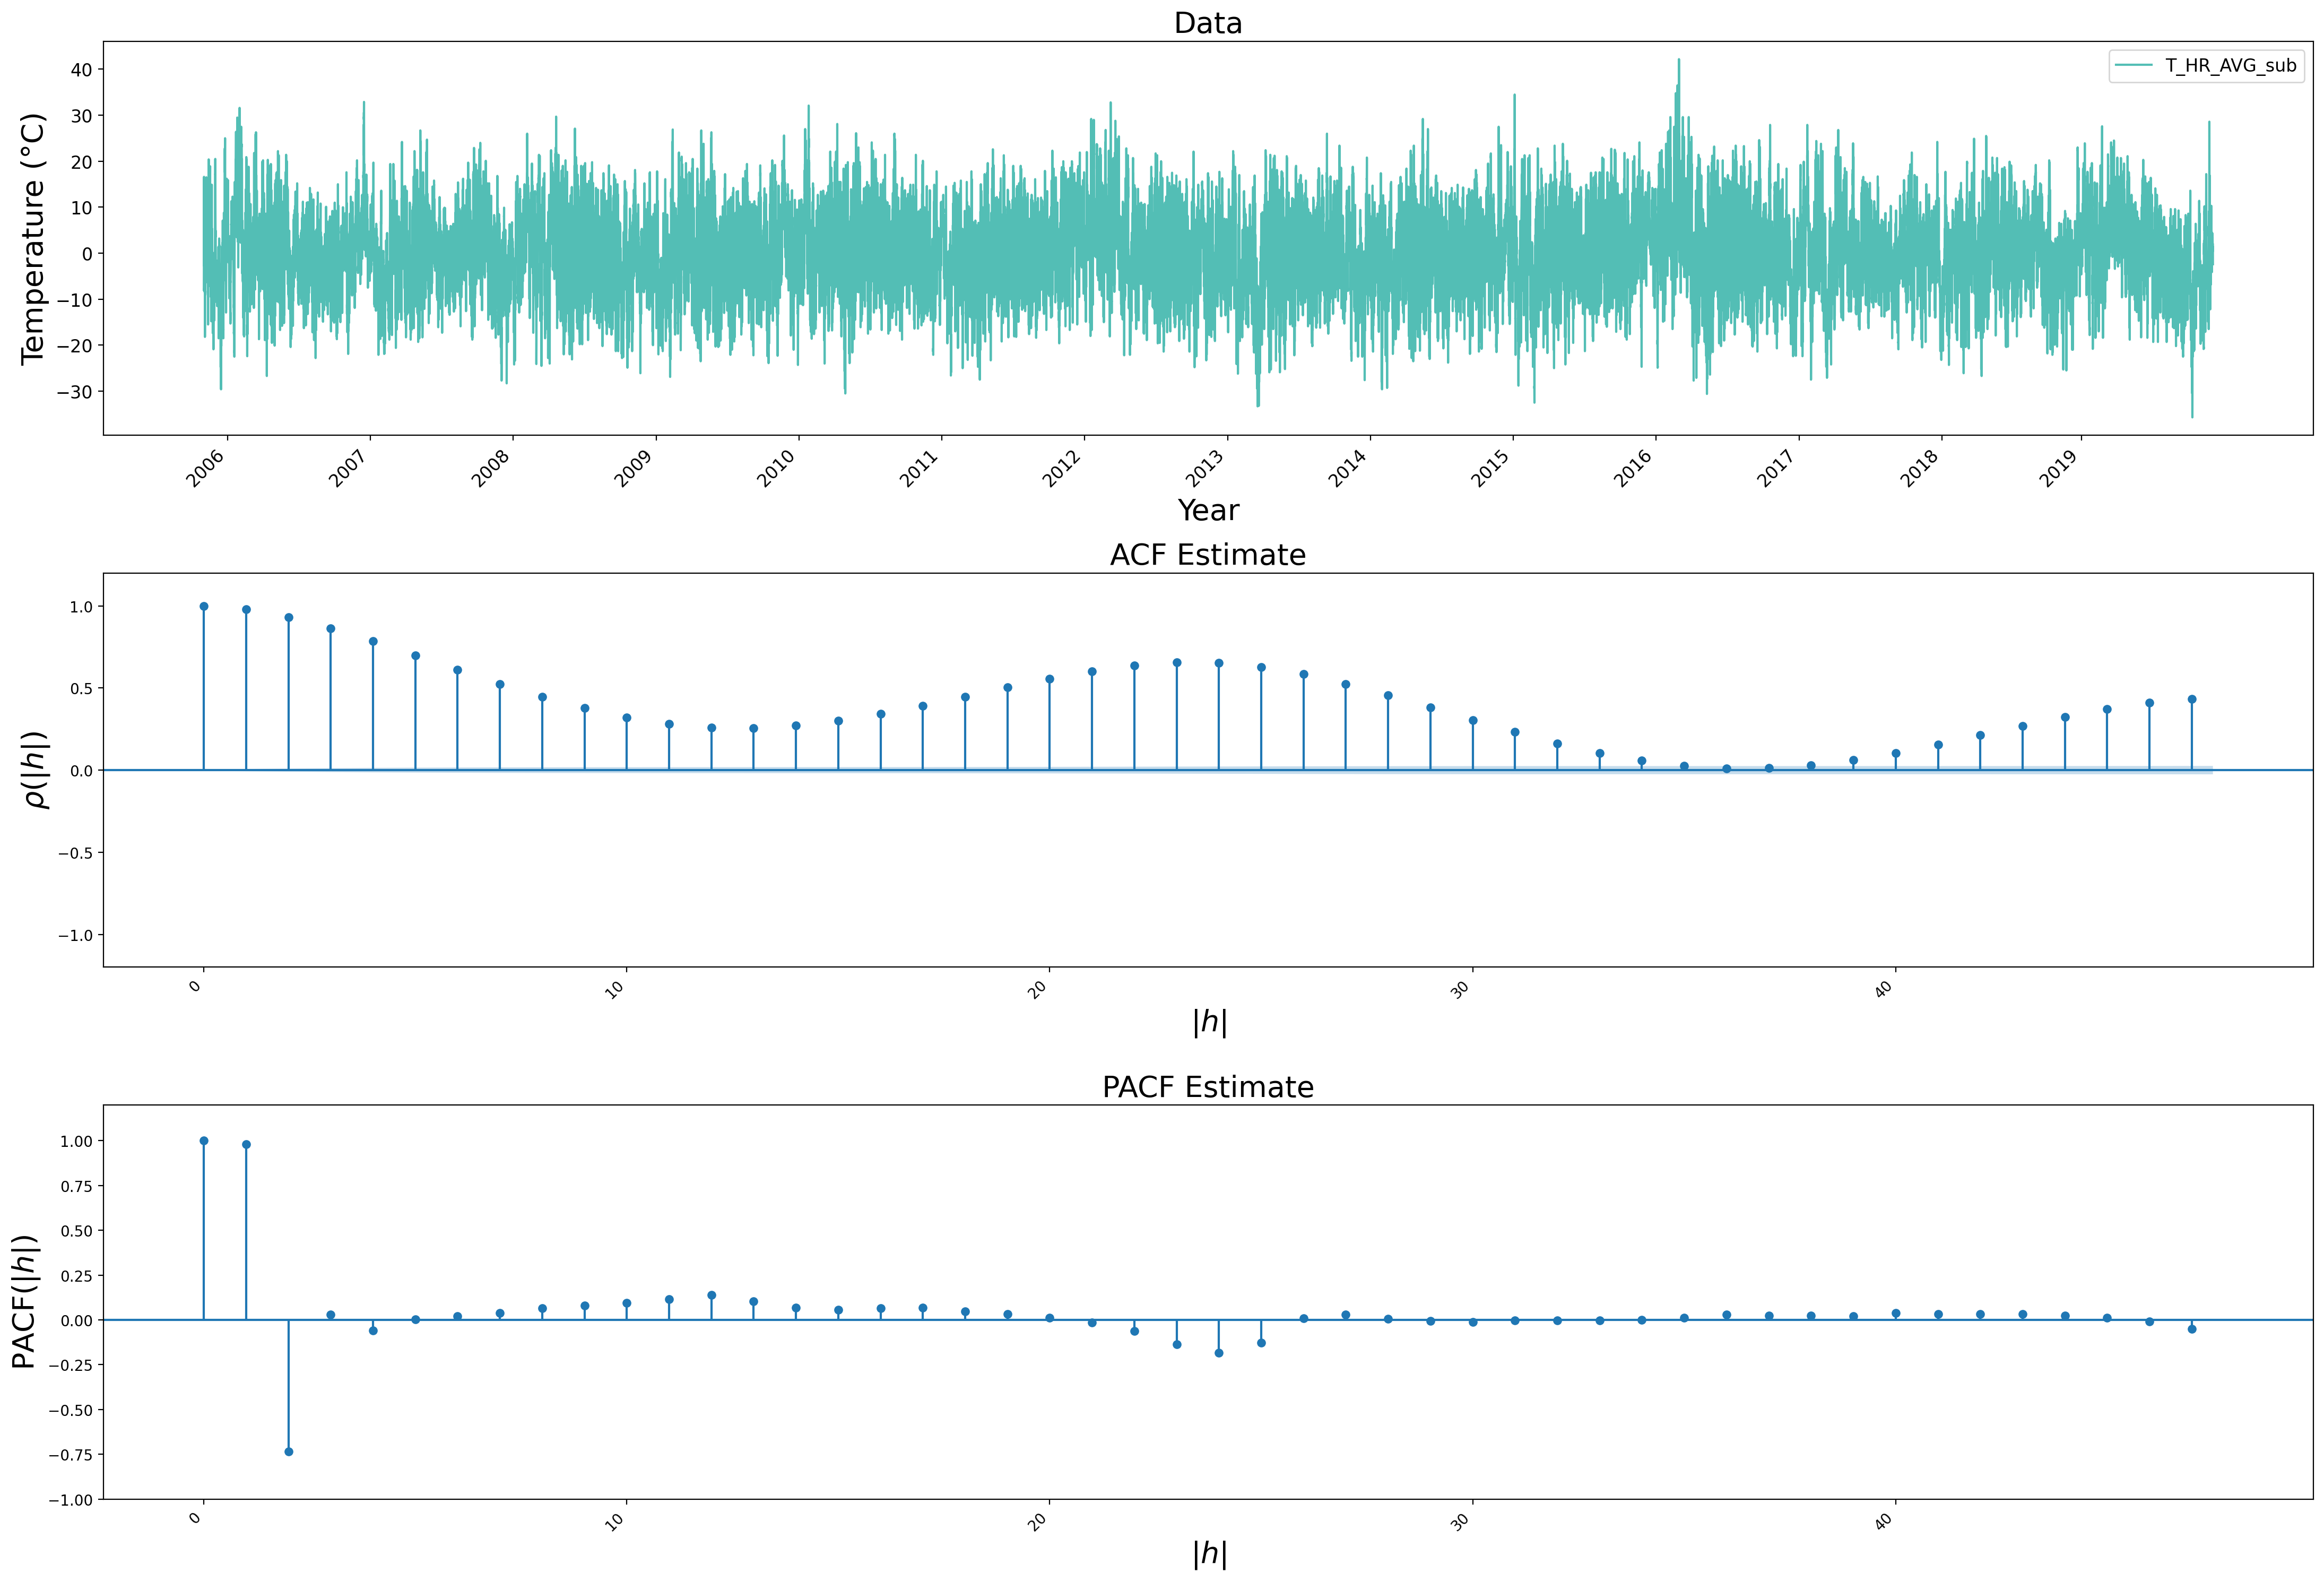

In [70]:
## P <= 3, Q <= 1; p <= 3, q <= 27
n_lags_ar = 48
n_lags_ma = 48
plot_triple_built_in(df = Ithaca_hourly_train_no_season,
                     n_lags_ar = n_lags_ar, n_lags_ma = n_lags_ma,
                     seasonality = 1, lag_ma = 1,
                     col = 'T_HR_AVG_sub',fig_name = 'hourly_p_q')

# How to handle remaining seasonality?
# Do I just fit one SARMA model with P, Q, s non-zero only?
# And subtract it from data?
# Further fit a SARMA model?

#### Search for best models

### Random Trial

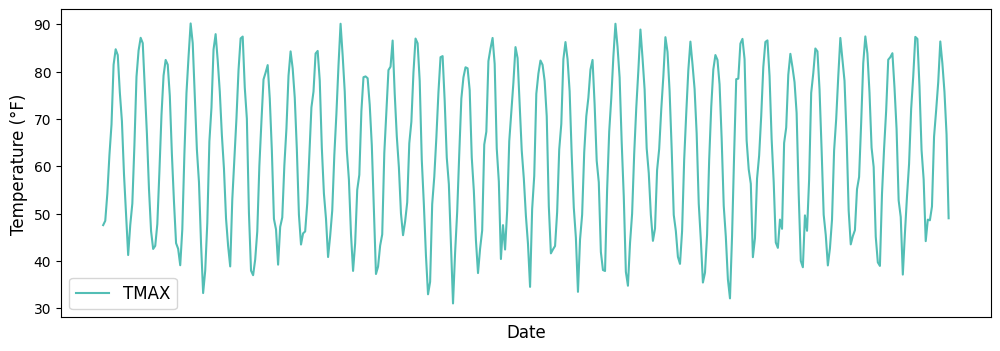

In [ ]:
## Let's aggregate by month
nyc_monthly = nyc_daily_drop.groupby(['year','month']).mean()
nyc_monthly.reset_index(inplace = True)

fontsize = 12
fig_overall, ax = plt.subplots(1,1, figsize = (12,4))
sns.lineplot(x = nyc_monthly.index, y = nyc_monthly['TMAX'],
              color = palette[1], label = 'TMAX', alpha = 0.9)
# sns.lineplot(x = nyc_monthly.index, y = nyc_monthly['TMIN'],
#               color = palette[-1], label = 'TMIN', alpha = 0.9)
ax.set_xticklabels([])
ax.set_xticks([])
ax.tick_params(axis = 'y', labelsize = 10)
ax.set_ylabel('Temperature (°F)', fontsize = fontsize)
ax.set_xlabel('Date', fontsize = fontsize)
ax.legend(fontsize = 12)
plt.show()

In [ ]:
nyc_monthly.index

MultiIndex([(1990,  1),
            (1990,  2),
            (1990,  3),
            (1990,  4),
            (1990,  5),
            (1990,  6),
            (1990,  7),
            (1990,  8),
            (1990,  9),
            (1990, 10),
            ...
            (2023,  2),
            (2023,  3),
            (2023,  4),
            (2023,  5),
            (2023,  6),
            (2023,  7),
            (2023,  8),
            (2023,  9),
            (2023, 10),
            (2023, 11)],
           names=['year', 'month'], length=407)

In [ ]:
## cp output to drive
!scp *.png drive/MyDrive/Colab\ Notebooks/